### Description: TwoD Case

This notebook is organized such that the first few blocks, up to "Basic analysis," perform the initial analysis and save the options for subsequent blocks. Therefore, the first few blocks need to be executed each time.

The analysis functions are implemented in a Python file at the base level to facilitate the generation of test functions and maintain version control. These functions are then called in the code blocks of the notebook, where additional plotting and organizing utilities are used to produce figures and tables.

### Package Import (Global)

In [1]:
import os, sys
import datetime
import numpy as np
import pandas as pd
from shutil import rmtree, copy
from matplotlib import pyplot as plt
from matplotlib import gridspec, cm
from PIL import Image, ImageDraw, ImageFont
from scipy.interpolate import interp1d, UnivariateSpline

# directory to the aspect Lab
ASPECT_LAB_DIR = os.environ['ASPECT_LAB_DIR']
RESULT_DIR = os.path.join(ASPECT_LAB_DIR, 'results')

sys.path.append(os.path.join(ASPECT_LAB_DIR))

import shilofue.TwoDSubduction0.Cases as TwoDCases
import shilofue.PlotCase as PlotCase
import shilofue.TwoDSubduction0.PlotCase as TwoDPlotCase
import shilofue.TwoDSubduction0.VtkPp as TwoDVtkPp
import shilofue.PlotDepthAverage as PlotDepthAverage
from shilofue.PlotCombine import PlotCombineExecute, PlotCombineFigures
from shilofue.PlotHeatFlow import HeatFlowRetriveProfile, HeatFlowRetriveZeroCrossings, group_adjacent_indices, HeatFlowRetriveForearcMaximumCase
from shilofue.TwoDSubduction0.PlotVisit import VISIT_OPTIONS, PREPARE_RESULT_OPTIONS
from shilofue.TwoDSubduction0.Group import CASE_SUMMARY

sys.path.append(os.path.join(ASPECT_LAB_DIR, 'utilities', "python_scripts"))
sys.path.append("/home/lochy/ASPECT_PROJECT/HaMaGeoLib/")
import Utilities

# py_temp file
py_temp_dir = os.path.join(ASPECT_LAB_DIR, "py_temp_files")
os.makedirs(py_temp_dir, exist_ok=True) # Ensure the directory exists

today_date = datetime.datetime.today().strftime("%Y-%m-%d") # Get today's date in YYYY-MM-DD format
py_temp_file = os.path.join(py_temp_dir, f"py_temp_{today_date}.sh")

if not os.path.exists(py_temp_file):
    bash_header = """#!/bin/bash
# =====================================================
# Script: py_temp.sh
# Generated on: {date}
# Description: Temporary Bash script created by Python
# =====================================================

""".format(date=today_date)
    with open(py_temp_file, "w") as f:
        f.write(bash_header)

print(f"File ensured at: {py_temp_file}")

File ensured at: /home/lochy/ASPECT_PROJECT/aspectLib/py_temp_files/py_temp_2025-02-26.sh


In [2]:
# import inspect
# from hamageolib import hamageolib_utils

# print("Everything:", dir(hamageolib_utils))

# # List all functions
# functions = [f for f in dir(hamageolib_utils) if inspect.isfunction(getattr(hamageolib_utils, f))]
# print("Functions:", functions)
	
# # List all classes
# classes = [c for c in dir(hamageolib_utils) if inspect.isclass(getattr(hamageolib_utils, c))]
# print("Classes:", classes)

In [3]:
import hamageolib
import hamageolib.utils.plot_helper as plot_helper
from hamageolib.utils.handy_shortcuts_haoyuan  import Mute
from hamageolib.core.melt import ROCK_MELTING

### Utility Functions

#### Function: `plot_pressure_temperature`
This function creates a subplot to visualize the relationship between depth and pressure with a twin axis for temperature. The main axis (`ax1`) plots pressure against depth, while the twin axis (`ax1_twin`) plots temperature against depth. The axis ranges, tick intervals, and labels are hard-coded to ensure consistent formatting. Legends for both axes are combined and displayed.

---

#### Function: `plot_viscosity_components`
This function creates a subplot to visualize the relationship between depth and viscosity components. The axis (`ax2`) plots diffusion, dislocation, and composite viscosities against depth using a logarithmic scale for the x-axis. The axis ranges, tick intervals, and labels are hard-coded to ensure consistent formatting. A legend is added to differentiate the viscosity components.

In [4]:
# Utility functions

from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from hamageolib.utils.file_reader  import read_aspect_header_file

import cv2


def create_avi_from_images(file_paths, output_file, frame_rate=30):
    """
    Converts a list of .png files into an .avi animation.

    Args:
        file_paths (list): List of file paths to .png images.
        output_file (str): The output .avi file path.
        frame_rate (int): The frame rate of the output animation. Defaults to 30.

    Returns:
        None
    """
    # Check if the file_paths list is empty
    if not file_paths:
        raise ValueError("The file_paths list is empty.")

    # Read the first image to get the frame size
    first_image = cv2.imread(file_paths[0])
    if first_image is None:
        raise ValueError(f"Cannot read the first image: {file_paths[0]}")

    height, width, _ = first_image.shape
    frame_size = (width, height)

    # Define the codec and create the VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for .avi
    out = cv2.VideoWriter(output_file, fourcc, frame_rate, frame_size)

    # Write each image to the video
    for file_path in file_paths:
        image = cv2.imread(file_path)
        if image is None:
            print(f"Warning: Skipping {file_path} (cannot read file).")
            continue
        resized_image = cv2.resize(image, frame_size)  # Ensure consistent size
        out.write(resized_image)

    # Release the VideoWriter object
    out.release()
    print(f"AVI animation created: {output_file}")


class SlabAnalysisPlotter:
    """
    A class for plotting slab analysis results with default plotting options.

    Attributes:
    - plot_options (dict): Default options for plotting, including time, trench, depth, and velocity ranges and intervals.
    """

    def __init__(self):
        """
        Initialize the SlabAnalysisPlotter with default plot options.
        """
        self.plot_options = {
            "time_range": (0, 15e6),
            "time_major_tick_interval": 5e6,
            "trench_range": (-500, 100),
            "trench_major_tick_interval": 100,
            "depth_range": (0, 1200),
            "depth_major_tick_interval": 200,
            "velocity_range": (-5, 10),
            "velocity_major_tick_interval": 5,
            "dip_range" : (30, 90),
            "dip_major_tick_interval": 10.0
        }

    def reset_plot_option(self, key, value):
        """
        Reset a specific plot option.

        Parameters:
        - key: str, The key in the plot_options dictionary to modify.
        - value: Any, The new value to set for the given key.

        Returns:
        - None
        """
        if key in self.plot_options:
            self.plot_options[key] = value
        else:
            raise KeyError(f"Invalid key '{key}'. Valid keys are: {list(self.plot_options.keys())}")

    def plot_slab_analysis(self, axes, local_comp_dir, Visit_Options, **kwargs):
        """
        Plot slab analysis results using the class's plot_options.

        Parameters:
        - axes: List of matplotlib Axes, length must be 2, with subplots for plotting.
        - base_comp_dir: str, Base directory of the computation case.
        - case_comp_name: str, Name of the specific case computation directory.
        - Visit_Options: Object, Configuration options for the simulation (including geometry details).

        Returns:
        - None
        """
        # Get additional options
        _color = kwargs.get("color", 'b')
        include_additional_label = kwargs.get("include_additional_label", False)
        _name = kwargs.get("name", None)
        marker_time = kwargs.get("time", None)

        # Assert that axes has the correct structure
        assert len(axes) == 2, "The 'axes' input must contain exactly two subplots."
        
        # Extract geometry and set outer radius
        geometry = Visit_Options.options["GEOMETRY"]
        if geometry == 'chunk':
            Ro = float(Visit_Options.options["OUTER_RADIUS"])
        else:
            Ro = -1.0  # Default value to indicate invalid geometry

        # Assert existence of the slab morphology file
        slab_morph_file = os.path.join(local_comp_dir, 'vtk_outputs', 'slab_morph.txt')
        if not os.path.isfile(slab_morph_file):
            raise FileNotFoundError(f"The file '{slab_morph_file}' does not exist.")

        # Read simulation log data
        pd_data = read_aspect_header_file(slab_morph_file)
        pvtu_steps = pd_data["pvtu_step"]
        times = pd_data["time"]
        trenches = pd_data["trench"]
        slab_depthes = pd_data["slab depth"]
        sp_velocities = pd_data["subducting plate velocity"]
        ov_velocities = pd_data["overiding plate velocity"]
        dip_100s = pd_data["100km dip"]

        # Extract plot options
        time_range = self.plot_options['time_range']
        time_major_tick_interval = self.plot_options['time_major_tick_interval']
        time_minor_tick_interval = time_major_tick_interval / 5.0
        trench_range = self.plot_options['trench_range']
        trench_major_tick_interval = self.plot_options['trench_major_tick_interval']
        trench_minor_tick_interval = trench_major_tick_interval / 5.0
        depth_range = self.plot_options['depth_range']
        depth_major_tick_interval = self.plot_options['depth_major_tick_interval']
        depth_minor_tick_interval = depth_major_tick_interval / 5.0
        velocity_range = self.plot_options['velocity_range']
        velocity_major_tick_interval = self.plot_options['velocity_major_tick_interval']
        velocity_minor_tick_interval = velocity_major_tick_interval / 5.0
        dip_range = self.plot_options["dip_range"]
        dip_major_tick_interval = self.plot_options["dip_major_tick_interval"]
        dip_minor_tick_interval = dip_major_tick_interval / 5.0

        # Calculate trench migration length
        if geometry == "chunk":
            trenches_migration_length = (trenches - trenches[0]) * Ro
        elif geometry == "box":
            trenches_migration_length = trenches - trenches[0]
        else:
            raise ValueError("Invalid geometry specified.")

        # Compute velocities
        trench_velocities = np.gradient(trenches_migration_length, times)
        sink_velocities = np.gradient(slab_depthes, times)

        # Plot "trench position" vs "time" on primary y-axis
        _label = 'Trench Position'
        if _name is not None:
            _label += f" ({_name})"
        line1, = axes[0].plot(times / 1e6, trenches_migration_length / 1e3, label=_label, linestyle='-', color=_color)
        axes[0].set_xlim(time_range[0] / 1e6, time_range[1] / 1e6)
        axes[0].set_xticks(np.arange(0, time_range[1] / 1e6 + 1, time_major_tick_interval / 1e6))
        axes[0].xaxis.set_minor_locator(MultipleLocator(time_minor_tick_interval / 1e6))
        axes[0].set_ylim(trench_range[0], trench_range[1])
        axes[0].set_yticks(np.arange(trench_range[0], trench_range[1] + 1, trench_major_tick_interval))
        axes[0].yaxis.set_minor_locator(MultipleLocator(trench_minor_tick_interval))
        axes[0].set_xlabel("Time (Ma)")
        axes[0].set_ylabel("Trench Position (km)")
        axes[0].tick_params(axis='y')
        # axes[0].grid()

        if marker_time is not None:
            axes[0].vlines(marker_time/1e6, trench_range[0], trench_range[1], color="gray", linestyle="dotted")

        # Plot "slab depth" vs "time" on twin y-axis
        ax_twin = axes[0].twinx()
        if include_additional_label:
            _label = 'Slab Depth'
        else:
            _label = None
        line2, = ax_twin.plot(times / 1e6, slab_depthes / 1e3, label=_label, linestyle='-.', color=_color)
        ax_twin.set_ylim(depth_range[0], depth_range[1])
        ax_twin.set_yticks(np.arange(depth_range[0], depth_range[1] + 1, depth_major_tick_interval))
        ax_twin.yaxis.set_minor_locator(MultipleLocator(depth_minor_tick_interval))
        ax_twin.set_ylabel("Slab Depth (km)")
        ax_twin.tick_params(axis='y')

        lines = [line1, line2]
        labels = [line.get_label() for line in lines]
        # axes[0].legend(lines, labels, loc="lower left") 

        # Plot velocities vs time on the second subplot
        if include_additional_label:
            _label = 'Trench Velocity'
        else:
            _label = None
        line2_0, = axes[1].plot(times / 1e6, trench_velocities * 1e2, label=_label, linestyle='-', color=_color)
        if include_additional_label:
            _label = 'Subducting Plate Velocity'
        else:
            _label = None
        line2_1, = axes[1].plot(times / 1e6, sp_velocities * 1e2, label=_label, linestyle='--', color=_color)
        
        if marker_time is not None:
            axes[1].vlines(marker_time/1e6, velocity_range[0], velocity_range[1], color="gray", linestyle="dotted")
        
        axes[1].set_xlim(time_range[0] / 1e6, time_range[1] / 1e6)
        axes[1].set_xticks(np.arange(0, time_range[1] / 1e6 + 1, time_major_tick_interval / 1e6))
        axes[1].xaxis.set_minor_locator(MultipleLocator(time_minor_tick_interval / 1e6))
        axes[1].set_ylim(velocity_range[0], velocity_range[1])
        axes[1].set_yticks(np.arange(velocity_range[0], velocity_range[1] + 1, velocity_major_tick_interval))
        axes[1].yaxis.set_minor_locator(MultipleLocator(velocity_minor_tick_interval))
        axes[1].set_xlabel("Time (Ma)")
        axes[1].set_ylabel("Velocity (cm/yr)")
        # axes[1].legend()
        # axes[1].grid()

        ax1_twin = axes[1].twinx()
        ax1_twin.set_ylim(dip_range[0], dip_range[1])
        line2_2, = ax1_twin.plot(times / 1e6, dip_100s * 180.0 / np.pi, label="Dip Angle", linestyle='dotted', color=_color)
        ax1_twin.set_yticks(np.arange(dip_range[0], dip_range[1] + 1, dip_major_tick_interval))
        ax1_twin.yaxis.set_minor_locator(MultipleLocator(dip_minor_tick_interval))
        ax1_twin.set_ylabel("Dip Angle (degree)")
        ax1_twin.tick_params(axis='y')

        lines = [line2_0, line2_1, line2_2]
        labels = [line.get_label() for line in lines]
        # axes[1].legend(lines, labels, loc="upper right") 

    def plot_slab_mdds(self, axes, local_comp_dir, Visit_Options, **kwargs):
        """
        Plot slab analysis results using the class's plot_options.

        Parameters:
        - axes: List of matplotlib Axes, length must be 2, with subplots for plotting.
        - base_comp_dir: str, Base directory of the computation case.
        - case_comp_name: str, Name of the specific case computation directory.
        - Visit_Options: Object, Configuration options for the simulation (including geometry details).

        Returns:
        - None
        """
        # Get additional options
        _color = kwargs.get("color", 'b')
        include_additional_label = kwargs.get("include_additional_label", False)
        _name = kwargs.get("name", None)
        marker_time = kwargs.get("time", None)

        # Assert that axes has the correct structure
        assert len(axes) == 2, "The 'axes' input must contain exactly two subplots."
        
        # Extract geometry and set outer radius
        geometry = Visit_Options.options["GEOMETRY"]
        if geometry == 'chunk':
            Ro = float(Visit_Options.options["OUTER_RADIUS"])
        else:
            Ro = -1.0  # Default value to indicate invalid geometry

        # Assert existence of the slab morphology file
        slab_morph_file = os.path.join(local_comp_dir, 'vtk_outputs', 'slab_morph.txt')
        if not os.path.isfile(slab_morph_file):
            raise FileNotFoundError(f"The file '{slab_morph_file}' does not exist.")

        # Read simulation log data
        pd_data = read_aspect_header_file(slab_morph_file)
        pvtu_steps = pd_data["pvtu_step"]
        times = pd_data["time"]
        trenches = pd_data["trench"]
        slab_depthes = pd_data["slab depth"]
        sp_velocities = pd_data["subducting plate velocity"]
        ov_velocities = pd_data["overiding plate velocity"]
        dip_100s = pd_data["100km dip"]
        mdd1s = pd_data["mechanical decoupling depth1"]
        mdd2s = pd_data["mechanical decoupling depth2"]

        # Extract plot options
        time_range = self.plot_options['time_range']
        time_major_tick_interval = self.plot_options['time_major_tick_interval']
        time_minor_tick_interval = time_major_tick_interval / 5.0
        trench_range = self.plot_options['trench_range']
        trench_major_tick_interval = self.plot_options['trench_major_tick_interval']
        trench_minor_tick_interval = trench_major_tick_interval / 5.0
        depth_range = self.plot_options['depth_range']
        depth_major_tick_interval = self.plot_options['depth_major_tick_interval']
        depth_minor_tick_interval = depth_major_tick_interval / 5.0
        velocity_range = self.plot_options['velocity_range']
        velocity_major_tick_interval = self.plot_options['velocity_major_tick_interval']
        velocity_minor_tick_interval = velocity_major_tick_interval / 5.0
        dip_range = (0, 90.0)
        mdd_range = (0, 150)
        mdd_major_tick_interval = 25.0
        mdd_minor_tick_interval = mdd_major_tick_interval / 5.0

        # Calculate trench migration length
        if geometry == "chunk":
            trenches_migration_length = (trenches - trenches[0]) * Ro
        elif geometry == "box":
            trenches_migration_length = trenches - trenches[0]
        else:
            raise ValueError("Invalid geometry specified.")

        # Compute velocities
        trench_velocities = np.gradient(trenches_migration_length, times)
        sink_velocities = np.gradient(slab_depthes, times)

        # Plot "trench position" vs "time" on primary y-axis
        _label = 'Trench Position'
        if _name is not None:
            _label += f" ({_name})"
        line1, = axes[0].plot(times / 1e6, trenches_migration_length / 1e3, label=_label, linestyle='-', color=_color)
        axes[0].set_xlim(time_range[0] / 1e6, time_range[1] / 1e6)
        axes[0].set_xticks(np.arange(0, time_range[1] / 1e6 + 1, time_major_tick_interval / 1e6))
        axes[0].xaxis.set_minor_locator(MultipleLocator(time_minor_tick_interval / 1e6))
        axes[0].set_ylim(trench_range[0], trench_range[1])
        axes[0].set_yticks(np.arange(trench_range[0], trench_range[1] + 1, trench_major_tick_interval))
        axes[0].yaxis.set_minor_locator(MultipleLocator(trench_minor_tick_interval))
        axes[0].set_xlabel("Time (Ma)")
        axes[0].set_ylabel("Trench Position (km)")
        axes[0].tick_params(axis='y')
        # axes[0].grid()

        if marker_time is not None:
            axes[0].vlines(marker_time/1e6, trench_range[0], trench_range[1], color="gray", linestyle="dotted")

        # Plot "slab depth" vs "time" on twin y-axis
        ax_twin = axes[0].twinx()
        if include_additional_label:
            _label = 'Slab Depth'
        else:
            _label = None
        line2, = ax_twin.plot(times / 1e6, slab_depthes / 1e3, label=_label, linestyle='-.', color=_color)
        ax_twin.set_ylim(depth_range[0], depth_range[1])
        ax_twin.set_yticks(np.arange(depth_range[0], depth_range[1] + 1, depth_major_tick_interval))
        ax_twin.yaxis.set_minor_locator(MultipleLocator(depth_minor_tick_interval))
        ax_twin.set_ylabel("Slab Depth (km)")
        ax_twin.tick_params(axis='y')

        lines = [line1, line2]
        labels = [line.get_label() for line in lines]
        # axes[0].legend(lines, labels, loc="lower left") 

        # Plot velocities vs time on the second subplot
        if include_additional_label:
            _label = 'Convergence Rate'
        else:
            _label = None
        line2_0, = axes[1].plot(times / 1e6, (sp_velocities - trench_velocities) * 1e2, label=_label, linestyle='-', color=_color)
        # line2_0, = axes[1].plot(times / 1e6, trench_velocities * 1e2, label=_label, linestyle='-', color=_color)
        # line2_1, = axes[1].plot(times / 1e6, sp_velocities * 1e2, label=_label, linestyle='--', color=_color)
        
        if marker_time is not None:
            axes[1].vlines(marker_time/1e6, velocity_range[0], velocity_range[1], color="gray", linestyle="dotted")
        
        axes[1].set_xlim(time_range[0] / 1e6, time_range[1] / 1e6)
        axes[1].set_xticks(np.arange(0, time_range[1] / 1e6 + 1, time_major_tick_interval / 1e6))
        axes[1].xaxis.set_minor_locator(MultipleLocator(time_minor_tick_interval / 1e6))
        axes[1].set_ylim(velocity_range[0], velocity_range[1])
        axes[1].set_yticks(np.arange(velocity_range[0], velocity_range[1] + 1, velocity_major_tick_interval))
        axes[1].yaxis.set_minor_locator(MultipleLocator(velocity_minor_tick_interval))
        axes[1].set_xlabel("Time (Ma)")
        axes[1].set_ylabel("Velocity (cm/yr)")
        # axes[1].legend()
        # axes[1].grid()

        ax1_twin = axes[1].twinx()
        # line2_2, = ax1_twin.plot(times / 1e6, dip_100s * 180.0 / np.pi, label="Dip Angle", linestyle='dotted', color=_color)
        line2_2, = ax1_twin.plot(times / 1e6, mdd1s/1e3, label="Decoupling Depth 1", linestyle='dotted', color=_color)
        line2_3, = ax1_twin.plot(times / 1e6, mdd2s/1e3, label="Decoupling Depth 2", linestyle='--', color=_color)
        ax1_twin.set_yticks(np.arange(mdd_range[0], mdd_range[1] + 1, mdd_major_tick_interval))
        ax1_twin.yaxis.set_minor_locator(MultipleLocator(mdd_minor_tick_interval))
        # ax1_twin.set_ylabel("Dip Angle (degree)")
        ax1_twin.set_ylabel("Decoupling depth (km)")
        ax1_twin.tick_params(axis='y')
        
        ax1_twin.set_ylim(mdd_range[0], mdd_range[1])

        lines = [line2_0, line2_2, line2_3]
        labels = [line.get_label() for line in lines]
        # axes[1].legend(lines, labels, loc="upper right") 


def plot_pressure_temperature(ax1, ax1_twin, depth, P, T):
    """
    Create a subplot to plot Depth vs Pressure with a twin axis for Temperature.
    
    Parameters:
    ax1 : matplotlib.axes.Axes
        Main axis for plotting pressure vs depth.
    ax1_twin : matplotlib.axes.Axes
        Twin axis for plotting temperature vs depth.
    depth : array-like
        Depth values (in meters).
    P : array-like
        Pressure values (in Pascals).
    T : array-like
        Temperature values (in Kelvin).
    """
    # Hard-coded limits and tick intervals
    depth_limit = (0, 3000)  # Depth axis range (in kilometers).
    depth_tick_interval = 500  # Tick interval for depth axis.
    P_limit = (0, 150)  # Pressure axis range (in GPa).
    P_tick_interval = 50.0  # Tick interval for pressure axis.
    T_limit = (0, 3000)  # Temperature axis range (in Kelvin).
    T_tick_interval = 1000.0  # Tick interval for temperature axis.

    # Plot Pressure vs Depth
    ax1.plot(P / 1e9, depth / 1e3, label="P", color="blue")  # Pressure plot in GPa and km.
    lines1, labels1 = ax1.get_legend_handles_labels()  # Gather legend entries.

    ax1.set_xlim(P_limit)
    ax1.xaxis.set_major_locator(MultipleLocator(P_tick_interval))
    ax1.xaxis.set_minor_locator(AutoMinorLocator(5))

    ax1.set_ylim(depth_limit)
    ax1.yaxis.set_major_locator(MultipleLocator(depth_tick_interval))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax1.set_xlabel("Pressure (GPa)")
    ax1.set_ylabel("Depth (km)")
    ax1.invert_yaxis()  # Depth increases downward.

    ax1.grid()

    # Plot Temperature vs Depth on the twin axis
    ax1_twin.plot(T, depth / 1e3, label="T", color="red")  # Temperature plot in Kelvin.
    lines2, labels2 = ax1_twin.get_legend_handles_labels()

    ax1_twin.set_xlim(T_limit)
    ax1_twin.xaxis.set_major_locator(MultipleLocator(T_tick_interval))

    ax1_twin.set_xlabel("Temperature (K)")

    # Combine legends for Pressure and Temperature plots
    combined_lines = lines1 + lines2
    combined_labels = labels1 + labels2
    ax1.legend(combined_lines, combined_labels, loc="lower left")


def plot_viscosity_components(ax2, depth, diffusion, dislocation, composite):
    """
    Create a subplot to plot Depth vs Viscosity components (diffusion, dislocation, and composite creep).
    
    Parameters:
    ax2 : matplotlib.axes.Axes
        Axis for plotting viscosity components vs depth.
    depth : array-like
        Depth values (in meters).
    diffusion : array-like
        Diffusion viscosity values.
    dislocation : array-like
        Dislocation viscosity values.
    composite : array-like
        Composite viscosity values.
    """
    # Hard-coded limits and tick intervals
    depth_limit = (0, 3000)  # Depth axis range (in kilometers).
    depth_tick_interval = 500  # Tick interval for depth axis.
    viscosity_limit = (1e18, 1e24)  # Viscosity axis range (in Pa·s, logarithmic scale).
    viscosity_ticks = [1e18, 1e19, 1e20, 1e21, 1e22, 1e23, 1e24]  # Tick values for viscosity axis.

    # Plot viscosity components vs Depth
    if diffusion is not None:
        ax2.plot(diffusion, depth / 1e3, label="Diffusion", color="c")  # Diffusion creep.
    if dislocation is not None:
        ax2.plot(dislocation, depth / 1e3, label="Dislocation", color="green")  # Dislocation creep.
    if composite is not None:
        ax2.plot(composite, depth / 1e3, linestyle="--", label="Composite", color="red")  # Composite creep.

    ax2.set_xscale("log")  # Logarithmic scale for viscosity.

    ax2.set_xlim(viscosity_limit)
    ax2.set_xticks(viscosity_ticks)

    ax2.set_ylim(depth_limit)
    ax2.yaxis.set_major_locator(MultipleLocator(depth_tick_interval))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax2.set_xlabel("Viscosity (Pa·s)")
    ax2.set_ylabel("Depth (km)")
    ax2.invert_yaxis()  # Depth increases downward.

    ax2.grid()
    ax2.legend()  # Add legend for the viscosity components.


def finalize_visualization_2d(local_dir, file_name, _time, frame_png_file_with_ticks, **kwargs):

    # Options
    add_time = kwargs.get("add_time", True)

    # Inputs
    eps_file = os.path.join(local_dir, "img", "pv_outputs", "%s_t%.4e.eps" % (file_name, _time))
    pdf_file = os.path.join(local_dir, "img", "pv_outputs", "%s_t%.4e.pdf" % (file_name, _time))

    if (not os.path.isfile(eps_file)) and (not os.path.isfile(pdf_file)):
        raise FileNotFoundError(f"Neither the EPS nor pdf exists: {eps_file}, {pdf_file}")

    if not os.path.isfile(frame_png_file_with_ticks):
        raise FileNotFoundError(f"The PNG file with ticks does not exist: {frame_png_file_with_ticks}")

    # Outputs
    # Paths to output files

    prep_file_dir = os.path.join(local_dir, "img", "prep")
    if not os.path.isdir(prep_file_dir):
        os.mkdir(prep_file_dir)

    output_image_file = os.path.join(prep_file_dir, "%s_t%.4e.png" % (file_name, _time))
    if os.path.isfile(output_image_file):
        # Remove existing output image to ensure a clean overlay
        os.remove(output_image_file)

    #If pdf is not provide, converts an EPS file to a PDF format using the plot_helper module.
    if not os.path.isfile(pdf_file):
        plot_helper.convert_eps_to_pdf(eps_file, pdf_file)
    assert(os.path.isfile(pdf_file))

    # Extracts an image from a PDF file with specific dimensions and an optional crop box.
    target_size = (1350, 704)  # Desired image dimensions in pixels
    crop_box = (200, 100, 1000, 700)  # Optional crop box to define the region of interest

    full_image_path = plot_helper.extract_image_by_size(pdf_file, target_size, os.path.join(local_dir, "img"), crop_box)

    # Overlays multiple images on a blank canvas with specified sizes, positions, cropping, and scaling.
    plot_helper.overlay_images_on_blank_canvas(
        canvas_size=(1700, 800),  # Size of the blank canvas in pixels (width, height)
        image_files=[full_image_path, frame_png_file_with_ticks],  # List of image file paths to overlay
        image_positions=[(-75, 64), (0, 0)],  # Positions of each image on the canvas
        cropping_regions=[None, None],  # Optional cropping regions for the images
        image_scale_factors=[1.20518518519, None],  # Scaling factors for resizing the images
        output_image_file=output_image_file  # Path to save the final combined image
    )

    # Example Usage, add_text_to_image
    # image_path = "your_image.png"  # Replace with the path to your PNG file
    # output_path = "output_image_with_text.png"  # Path to save the output image
    if add_time:
        text = "t = %.1f Ma" % (_time / 1e6)  # Replace with the text you want to add
        position = (25, 25)  # Replace with the desired text position (x, y)
        font_path = "/usr/share/fonts/truetype/msttcorefonts/times.ttf"  # Path to Times New Roman font
        font_size = 72

        plot_helper.add_text_to_image(output_image_file, output_image_file, text, position, font_path, font_size)

    return output_image_file


def finalize_visualization_2d_12172024(local_dir, file_name, _time, frame_png_file_with_ticks, **kwargs):

    # Options
    add_time = kwargs.get("add_time", True)

    # Inputs
    eps_file = os.path.join(local_dir, "img", "pv_outputs", "%s_t%.4e.eps" % (file_name, _time))
    pdf_file = os.path.join(local_dir, "img", "pv_outputs", "%s_t%.4e.pdf" % (file_name, _time))

    if (not os.path.isfile(eps_file)) and (not os.path.isfile(pdf_file)):
        raise FileNotFoundError(f"Neither the EPS nor pdf exists: {eps_file}, {pdf_file}")

    if not os.path.isfile(frame_png_file_with_ticks):
        raise FileNotFoundError(f"The PNG file with ticks does not exist: {frame_png_file_with_ticks}")

    # Outputs
    # Paths to output files

    prep_file_dir = os.path.join(local_dir, "img", "prep")
    if not os.path.isdir(prep_file_dir):
        os.mkdir(prep_file_dir)

    output_image_file = os.path.join(prep_file_dir, "%s_t%.4e.png" % (file_name, _time))
    if os.path.isfile(output_image_file):
        # Remove existing output image to ensure a clean overlay
        os.remove(output_image_file)

    #If pdf is not provide, converts an EPS file to a PDF format using the plot_helper module.
    if not os.path.isfile(pdf_file):
        plot_helper.convert_eps_to_pdf(eps_file, pdf_file)
    assert(os.path.isfile(pdf_file))

    # Extracts an image from a PDF file with specific dimensions and an optional crop box.
    target_size = (1350, 704)  # Desired image dimensions in pixels
    crop_box = (200, 100, 1000, 700)  # Optional crop box to define the region of interest

    full_image_path = plot_helper.extract_image_by_size(pdf_file, target_size, os.path.join(local_dir, "img"), crop_box)

    # Overlays multiple images on a blank canvas with specified sizes, positions, cropping, and scaling.
    plot_helper.overlay_images_on_blank_canvas(
        canvas_size=(996, 568),  # Size of the blank canvas in pixels (width, height)
        image_files=[full_image_path, frame_png_file_with_ticks],  # List of image file paths to overlay
        image_positions=[(-102, -9), (0, 0)],  # Positions of each image on the canvas
        cropping_regions=[None, None],  # Optional cropping regions for the images
        image_scale_factors=[0.81185, None],  # Scaling factors for resizing the images
        output_image_file=output_image_file  # Path to save the final combined image
    )

    # Example Usage, add_text_to_image
    # image_path = "your_image.png"  # Replace with the path to your PNG file
    # output_path = "output_image_with_text.png"  # Path to save the output image
    if add_time:
        text = "t = %.1f Ma" % (_time / 1e6)  # Replace with the text you want to add
        position = (25, 25)  # Replace with the desired text position (x, y)
        font_path = "/usr/share/fonts/truetype/msttcorefonts/times.ttf"  # Path to Times New Roman font
        font_size = 72

        plot_helper.add_text_to_image(output_image_file, output_image_file, text, position, font_path, font_size)

    return output_image_file

def finalize_visualization_2d_wedge_12202024(local_dir, file_name, _time, frame_png_file_with_ticks, **kwargs):

    # Options
    add_time = kwargs.get("add_time", True)

    canvas_size = kwargs.get("canvas_size", (650, 450))

    # Inputs
    eps_file = os.path.join(local_dir, "img", "pv_outputs", "%s_t%.4e.eps" % (file_name, _time))
    pdf_file = os.path.join(local_dir, "img", "pv_outputs", "%s_t%.4e.pdf" % (file_name, _time))

    if (not os.path.isfile(eps_file)) and (not os.path.isfile(pdf_file)):
        raise FileNotFoundError(f"Neither the EPS nor pdf exists: {eps_file}, {pdf_file}")

    if not os.path.isfile(frame_png_file_with_ticks):
        raise FileNotFoundError(f"The PNG file with ticks does not exist: {frame_png_file_with_ticks}")

    # Outputs
    # Paths to output files

    prep_file_dir = os.path.join(local_dir, "img", "prep")
    if not os.path.isdir(prep_file_dir):
        os.mkdir(prep_file_dir)

    output_image_file = os.path.join(prep_file_dir, "%s_t%.4e.png" % (file_name, _time))
    if os.path.isfile(output_image_file):
        # Remove existing output image to ensure a clean overlay
        os.remove(output_image_file)

    #If pdf is not provide, converts an EPS file to a PDF format using the plot_helper module.
    if not os.path.isfile(pdf_file):
        plot_helper.convert_eps_to_pdf(eps_file, pdf_file)
    assert(os.path.isfile(pdf_file))

    # Extracts an image from a PDF file with specific dimensions and an optional crop box.
    target_size = (1350, 704)  # Desired image dimensions in pixels
    crop_box = (200, 100, 1000, 700)  # Optional crop box to define the region of interest

    full_image_path = plot_helper.extract_image_by_size(pdf_file, target_size, os.path.join(local_dir, "img"), crop_box)

    # Overlays multiple images on a blank canvas with specified sizes, positions, cropping, and scaling.
    plot_helper.overlay_images_on_blank_canvas(
        canvas_size=canvas_size,  # Size of the blank canvas in pixels (width, height)
        image_files=[full_image_path, frame_png_file_with_ticks],  # List of image file paths to overlay
        image_positions=[(-90, 5), (0, 0)],  # Positions of each image on the canvas
        cropping_regions=[None, None],  # Optional cropping regions for the images
        image_scale_factors=[0.661481, None],  # Scaling factors for resizing the images
        output_image_file=output_image_file  # Path to save the final combined image
    )

    # Example Usage, add_text_to_image
    # image_path = "your_image.png"  # Replace with the path to your PNG file
    # output_path = "output_image_with_text.png"  # Path to save the output image
    if add_time:
        text = "t = %.1f Ma" % (_time / 1e6)  # Replace with the text you want to add
        position = (25, 25)  # Replace with the desired text position (x, y)
        font_path = "/usr/share/fonts/truetype/msttcorefonts/times.ttf"  # Path to Times New Roman font
        font_size = 72

        plot_helper.add_text_to_image(output_image_file, output_image_file, text, position, font_path, font_size)

    return output_image_file



def finalize_visualization_2d_wedge_02122025(local_dir, file_name, _time, frame_png_file_with_ticks, **kwargs):
    # Options
    add_time = kwargs.get("add_time", True)

    # Inputs
    eps_file = os.path.join(local_dir, "img", "pv_outputs", "%s_t%.4e.eps" % (file_name, _time))
    pdf_file = os.path.join(local_dir, "img", "pv_outputs", "%s_t%.4e.pdf" % (file_name, _time))

    if (not os.path.isfile(eps_file)) and (not os.path.isfile(pdf_file)):
        raise FileNotFoundError(f"Neither the EPS nor pdf exists: {eps_file}, {pdf_file}")

    if not os.path.isfile(frame_png_file_with_ticks):
        raise FileNotFoundError(f"The PNG file with ticks does not exist: {frame_png_file_with_ticks}")

    # Outputs
    # Paths to output files
    prep_file_dir = os.path.join(local_dir, "img", "prep")
    if not os.path.isdir(prep_file_dir):
        os.mkdir(prep_file_dir)

    output_image_file = os.path.join(prep_file_dir, "%s_t%.4e.png" % (file_name, _time))
    if os.path.isfile(output_image_file):
        # Remove existing output image to ensure a clean overlay
        os.remove(output_image_file)

    # If pdf is not provided, converts an EPS file to a PDF format using the plot_helper module.
    if not os.path.isfile(pdf_file):
        plot_helper.convert_eps_to_pdf(eps_file, pdf_file)
    assert os.path.isfile(pdf_file)

    # Extracts an image from a PDF file with specific dimensions and an optional crop box.
    target_size = (1350, 704)  # Desired image dimensions in pixels
    crop_box = (200, 100, 1000, 700)  # Optional crop box to define the region of interest

    full_image_path = plot_helper.extract_image_by_size(pdf_file, target_size, os.path.join(local_dir, "img"), crop_box)

    # Overlays multiple images on a blank canvas with specified sizes, positions, cropping, and scaling.
    plot_helper.overlay_images_on_blank_canvas(
        canvas_size=(1050, 770),  # Size of the blank canvas in pixels (width, height)
        image_files=[full_image_path, frame_png_file_with_ticks],  # List of image file paths to overlay
        image_positions=[(-33, 13), (0, 0)],  # Positions of each image on the canvas
        cropping_regions=[None, None],  # Optional cropping regions for the images
        image_scale_factors=[0.9370, None],  # Scaling factors for resizing the images
        output_image_file=output_image_file  # Path to save the final combined image
    )

    # Example Usage, add_text_to_image
    if add_time:
        text = "t = %.1f Ma" % (_time / 1e6)  # Replace with the text you want to add
        position = (25, 25)  # Replace with the desired text position (x, y)
        font_path = "/usr/share/fonts/truetype/msttcorefonts/times.ttf"  # Path to Times New Roman font
        font_size = 72

        plot_helper.add_text_to_image(output_image_file, output_image_file, text, position, font_path, font_size)

    return output_image_file



### Preliminaries

#### System path

The path to the project directory

    local_TwoDSubduction_dir

The path to the project directory on server

    remote_TwoDSubduction_dir

In [5]:
local_TwoDSubduction_dir = "/mnt/lochz/ASPECT_DATA/TwoDSubduction"
local_EntropySub_dir = "/mnt/lochy/ASPECT_DATA/EntropySubduction"
remote_TwoDSubduction_dir = "peloton:/group/billengrp-mpi-io/lochy/TwoDSubduction"

assert(os.path.isdir(local_TwoDSubduction_dir))

#### case name

case name (relative path to local_TwoDSubduction_dir)

    case_name

In [6]:
from hamageolib.utils.case_options import CASE_OPTIONS

# case_name = "EBA_CDPT_refine_wedge2/eba_cdpt_SA80.0_ct7.5_cd50.0_gr11"
# case_name = "EBA_CDPT_refine_wedge2/eba_cdpt_SA80.0_ct7.5_cd60.0_gr11"
# case_name = "EBA_CDPT_refine_wedge2/eba_cdpt_SA80.0_ct7.5_cd70.0_gr11"
# case_name = "EBA_CDPT_refine_wedge2/eba_cdpt_SA80.0_ct7.5_cd80.0_gr11"
# case_name = "EBA_CDPT_refine_wedge2/eba_cdpt_SA80.0_ct7.5_cd90.0_gr11"

case_name = "EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11"
# case_name = "EBA_CDPT_test_gr_1/eba_cdpt_PTWL_SA80.0_cd7.5_gr11"


local_dir = os.path.join(local_TwoDSubduction_dir, case_name)

assert(os.path.isdir(local_dir))

CaseOptions = CASE_OPTIONS(local_dir)

### Basic Analysis

Plot Linear results and prepare the scripts for visualization

The next block will generate plots of runtime, solver statistics, etc. It will also compose a script to run in ParaView or VisIt.

It is preferred to first run the next block for slab morphology, analyze the result, and fix the steps to visualize in this block.

The max_velocity is useful for rescaling the color for the velocity. To pick a reasonable value, first view the range from outputs with max_velocity set to -1.0. The unit to use is m/yr.

#### Paraview scripts

In [7]:
# define a function for round values
round_values = lambda values: [round(x) for x in values]

# turn on plot_axis if I want to save a complete result
# turn off if I want to prepare for figures in a paper
plot_axis = False

graphical_steps = [124]; slices=None # 1. specify steps
# time_interval = 5e5 # 2. use a time interval
# resampled_df = CaseOptions.resample_visualization_df(time_interval)
# graphical_steps = round_values(resampled_df["Time"].values / float(resampled_df.attrs["Time between graphical output"]))
# slices = None

# step = "auto"; slices=3  # auto-figure out the steps, take the numebr of slices
max_velocity = -1.0  # rescale the color for velocity
# apply an additional rotation in addition to the initial trench angle


# types of plot to include
# The available types of plots are
# plot_types = ["upper_mantle", "whole", "whole_whole"]
# plot_types = ["upper_mantle"]; rotation_plus = - 0.02 # for plotting the upper mantle
# plot_types = ["wedge_bigger"]; rotation_plus = 4.22 # 
# plot_types = ["wedge"]; rotation_plus = 2.0 - 0.03 # 
plot_types = ["wedge_02252025"]; rotation_plus = 2.0 - 0.03 # 
# plot_types = ["wedge_small"]; rotation_plus = 1.25 - 0.03 # 

# The "additional_fields" will be added to the fields to plot.
# It could be useful to add field like the different layers of
# the crust that are not loaded by default
# additional_fields = ["spcrust_up", "spcrust_low"]  # in case of two crustal layers
additional_fields = [] # in case of one crustal layer

PlotCase.PlotCaseRun(local_dir, time_range=None, run_visual=False,\
        time_interval=None, visualization="paraview", step=graphical_steps)
plt.close() # plot won't show up below

Visit_Options = TwoDPlotCase.PlotCaseRun(local_dir, time_range=None, run_visual=False,\
        time_interval=None, visualization="paraview", step=graphical_steps, plot_axis=plot_axis, max_velocity=max_velocity, plot_types=plot_types,
        rotation_plus=rotation_plus, additional_fields=additional_fields, slices=slices)
plt.close() # plot won't show up below

# check and output
paraview_script = os.path.join(local_dir, "paraview_scripts", "slab.py")
assert(os.path.isfile(paraview_script))
with open(py_temp_file, 'a') as fout:
    fout.write("# Run paraview script\n")
    fout.write("pvpython %s\n" % paraview_script)

PlotCaseRun: operating
Ploting statistic results


/home/lochy/ASPECT_PROJECT/aspectLib/shilofue/Plot.py:308: DataNotFoundWarning: The field Outward_heat_flux_through_boundary_with_indicator_1 doesn't exist. We will keep ploting,but you will get a blank one for this field name
  self.DataNotFoundWarning)
/home/lochy/ASPECT_PROJECT/aspectLib/shilofue/Plot.py:308: DataNotFoundWarning: The field Outward_heat_flux_through_boundary_with_indicator_2 doesn't exist. We will keep ploting,but you will get a blank one for this field name
  self.DataNotFoundWarning)
/home/lochy/ASPECT_PROJECT/aspectLib/shilofue/Plot.py:308: DataNotFoundWarning: The field Outward_heat_flux_through_boundary_with_indicator_3 doesn't exist. We will keep ploting,but you will get a blank one for this field name
  self.DataNotFoundWarning)
/home/lochy/ASPECT_PROJECT/aspectLib/shilofue/Plot.py:308: DataNotFoundWarning: The field Global_mass_for_composition_C_1 doesn't exist. We will keep ploting,but you will get a blank one for this field name
  self.DataNotFoundWarning)


New figure: /mnt/lochz/ASPECT_DATA/TwoDSubduction/EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11/img/Statistic.png
Ploting run time
awk -f /home/lochy/ASPECT_PROJECT/aspectLib/bash_scripts/awk_states/parse_block_output /mnt/lochz/ASPECT_DATA/TwoDSubduction/EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11/output/log.txt > /mnt/lochz/ASPECT_DATA/TwoDSubduction/EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11/output/py_outputs/run_time_output
New figure: /mnt/lochz/ASPECT_DATA/TwoDSubduction/EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11/img/run_time.png
solver_scheme,  single Advection, iterated defect correction Stokes
Plotting newton solver history
awk -f /home/lochy/ASPECT_PROJECT/aspectLib/bash_scripts/awk_states/parse_block_newton /mnt/lochz/ASPECT_DATA/TwoDSubduction/EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11/output/log.txt > /home/lochy/ASPECT_PROJECT/aspectLib/results/run_time_output_newton
New figure (new): /mnt/lochz/ASPECT_DATA/TwoDSubduction/EBA_CDPT_test_

#### Paraview scripts stepwise

To generate for animation, we follow stepwise variables, for example the trench position.

In the following script:

    - The plot is rotated so that the trench is put inside the plot region.
    - Separate scripts are generate for the time steps.
    - A bash script to run them in batch is generated.

In [8]:
# todo_split
generate_paraview_script_stepwise = False

time_interval = 5e5

if generate_paraview_script_stepwise:

    # options in plot
    diff_angle = 1.5 # deg, to match the frame we use
    Visit_Options.options["PLOT_TYPES"] = ["wedge_bigger"]

    # step
    resampled_df = CaseOptions.resample_visualization_df(time_interval)
    graphical_steps = round_values(resampled_df["Time"].values / float(resampled_df.attrs["Time between graphical output"]))

    # Assert existence of the slab morphology file
    slab_morph_file = os.path.join(local_dir, 'vtk_outputs', 'slab_morph_t1.00e+05.txt')
    if not os.path.isfile(slab_morph_file):
        raise FileNotFoundError(f"The file '{slab_morph_file}' does not exist.")

    # Read simulation log data
    pd_data = read_aspect_header_file(slab_morph_file)
    pvtu_steps = pd_data["pvtu_step"]
    times = pd_data["time"]
    trenches = pd_data["trench"]
    shallow_trenches = pd_data["shallow trench"]
    slab_depthes = pd_data["slab depth"]
    sp_velocities = pd_data["subducting plate velocity"]
    ov_velocities = pd_data["overiding plate velocity"]

    # Make the directory to hold the scripts
    print("Generating paraview scripts")
    odir = os.path.join(local_dir, 'paraview_scripts', "stepwise")
    if not os.path.isdir(odir):
        os.mkdir(odir)

    # generate paraview scripts
    for i, graphical_step in enumerate(graphical_steps):        
        print("i: ", i)
        print("graphical_step:", graphical_step)
        Visit_Options.options['GRAPHICAL_STEPS'] = [graphical_step]

        _time = float(resampled_df.attrs["Time between graphical output"]) * graphical_step
        i1 = (np.abs(times - _time)).argmin() # index nearest to _time
        trench = shallow_trenches[i1]
        trench_deg = trench * 180.0 / np.pi

        ofile = os.path.join(odir, 'slab_%d.py' % (graphical_step))
        paraview_script = os.path.join(ASPECT_LAB_DIR, 'paraview_scripts', 'TwoDSubduction', "slab.py")
        paraview_script_base = os.path.join(ASPECT_LAB_DIR, 'paraview_scripts', 'base.py')
        Visit_Options.read_contents(paraview_script_base, paraview_script)  # combine these two scripts

        Visit_Options.options['ROTATION_ANGLE'] = 90.0 - trench_deg - diff_angle
        print("ROTATION_ANGLE:", Visit_Options.options['ROTATION_ANGLE'])
        # todo_split
        Visit_Options.substitute()

        Visit_Options.save(ofile)

        print("Generate %s" % ofile)

    # append command to bash script
    with open(py_temp_file, 'a') as fout:
        
        for i, graphical_step in enumerate(graphical_steps):
        
            ofile = os.path.join(odir, 'slab_%d.py' % (graphical_step))

            fout.write("# Run slab morphology analysis\n")
            fout.write("pvpython %s\n" % ofile)

#### pinpointing

In [9]:
# in case of the chunk geometry, query the cartesian coordinates of a spherical point
# this is useful to interact with Paraview slices

r = Visit_Options.options['OUTER_RADIUS']

rotation_lon = Visit_Options.options['ROTATION_ANGLE'] # + rotation_plus # automatic rotation
# rotation_lon = 54.5689 # assign rotation
# 
print("rotation angle = ", rotation_lon)
print("lon at 90 deg (top) = ", 90.0 - rotation_lon)

## Deal with solution.vtu
# x, y, z = Utilities.ggr2cart(0.0,trench_lon / 180.0 * np.pi,r - 5e3) # query a point near slab edge

## Deal with transform (a rotation is applied)
pin_lon = 37.5 # deg
depth = 0
x, y, z = Utilities.ggr2cart(0.0,(pin_lon+rotation_lon) / 180.0 * np.pi,r - depth) # query a point near slab edge;

print("(x, y, z) = (%.3f, %.3f, %.3f)" % (x, y, z))

rotation angle =  53.997135763250775
lon at 90 deg (top) =  36.002864236749225
(x, y, z) = (-166454.958, 6368825.147, 0.000)


#### Automazed workflow to finalize visualization

Found 4 image(s) on the page.
Found matching image with dimensions: 1350x704
Saved the full figure as /mnt/lochz/ASPECT_DATA/TwoDSubduction/EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11/img/real_figure.png
Original size of image 1: (1350, 704)
Cropped size of image 1: (1350, 704)
Scaled size of image 1: (733, 382)
Original size of image 2: (810, 415)
Cropped size of image 2: (810, 415)
Scaled size of image 2: (810, 415)
Overlay completed. Final image saved as /mnt/lochz/ASPECT_DATA/TwoDSubduction/EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11/img/prep/spcrust_wedge_02252025_t1.2400e+07.png


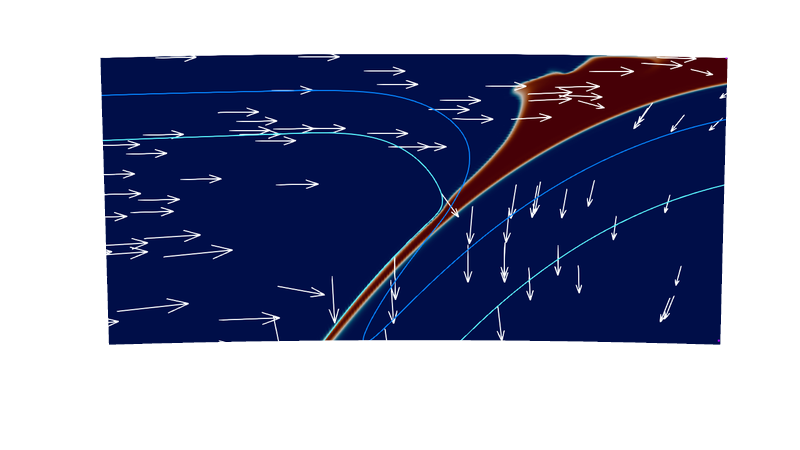

Saved plot:  /mnt/lochz/ASPECT_DATA/TwoDSubduction/EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11/img/prep/spcrust_wedge_02252025_t1.2400e+07.png


In [19]:

finalize_visual = True

def finalize_visualization_2d_wedge_02252025(local_dir, file_name, _time, frame_png_file_with_ticks, **kwargs):

    # Options
    add_time = kwargs.get("add_time", True)

    canvas_size = kwargs.get("canvas_size", (800, 450))

    # Inputs
    eps_file = os.path.join(local_dir, "img", "pv_outputs", "%s_t%.4e.eps" % (file_name, _time))
    pdf_file = os.path.join(local_dir, "img", "pv_outputs", "%s_t%.4e.pdf" % (file_name, _time))

    if (not os.path.isfile(eps_file)) and (not os.path.isfile(pdf_file)):
        raise FileNotFoundError(f"Neither the EPS nor pdf exists: {eps_file}, {pdf_file}")

    if not os.path.isfile(frame_png_file_with_ticks):
        raise FileNotFoundError(f"The PNG file with ticks does not exist: {frame_png_file_with_ticks}")

    # Outputs
    # Paths to output files

    prep_file_dir = os.path.join(local_dir, "img", "prep")
    if not os.path.isdir(prep_file_dir):
        os.mkdir(prep_file_dir)

    output_image_file = os.path.join(prep_file_dir, "%s_t%.4e.png" % (file_name, _time))
    if os.path.isfile(output_image_file):
        # Remove existing output image to ensure a clean overlay
        os.remove(output_image_file)

    #If pdf is not provide, converts an EPS file to a PDF format using the plot_helper module.
    if not os.path.isfile(pdf_file):
        plot_helper.convert_eps_to_pdf(eps_file, pdf_file)
    assert(os.path.isfile(pdf_file))

    # Extracts an image from a PDF file with specific dimensions and an optional crop box.
    target_size = (1350, 704)  # Desired image dimensions in pixels
    crop_box = (200, 100, 1000, 700)  # Optional crop box to define the region of interest

    full_image_path = plot_helper.extract_image_by_size(pdf_file, target_size, os.path.join(local_dir, "img"), crop_box)

    # Overlays multiple images on a blank canvas with specified sizes, positions, cropping, and scaling.
    plot_helper.overlay_images_on_blank_canvas(
        canvas_size=canvas_size,  # Size of the blank canvas in pixels (width, height)
        image_files=[full_image_path, frame_png_file_with_ticks],  # List of image file paths to overlay
        image_positions=[(45, -5), (0, 0)],  # Positions of each image on the canvas
        cropping_regions=[None, None],  # Optional cropping regions for the images
        image_scale_factors=[0.542963, 1.0],  # Scaling factors for resizing the images
        output_image_file=output_image_file  # Path to save the final combined image
    )

    # Example Usage, add_text_to_image
    # image_path = "your_image.png"  # Replace with the path to your PNG file
    # output_path = "output_image_with_text.png"  # Path to save the output image
    if add_time:
        text = "t = %.1f Ma" % (_time / 1e6)  # Replace with the text you want to add
        position = (25, 25)  # Replace with the desired text position (x, y)
        font_path = "/usr/share/fonts/truetype/msttcorefonts/times.ttf"  # Path to Times New Roman font
        font_size = 72

        plot_helper.add_text_to_image(output_image_file, output_image_file, text, position, font_path, font_size)

    return output_image_file

if finalize_visual:

    from IPython.display import Image, display

    _time = 12.4e6
    
    # file types
    # file_name = "viscosity"
    # file_name = "T"
    # file_name = "spcrust_wedge"
    # file_name = "T_wedge"

    # file_name = "T_wedge_02252025"
    file_name = "spcrust_wedge_02252025"

    # file_name = "T_wedge_bigger"
    # file_name = "viscosity_wedge"
    # file_name = "strain_rate_wedge"
    # file_name = "DM_wedge"
    

    if file_name in ["viscosity", "T"]:
        # frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/TwoDSubduction/upper_mantle_frame/upper_mantle_frame_03132024_trans_with_frame-01.png"
        frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/TwoDSubduction/upper_mantle_frame/upper_mantle_frame_12172024_trans-01.png"
        
        output_image_file = finalize_visualization_2d_12172024(local_dir, file_name, _time, frame_png_file_with_ticks, add_time=False)

    elif file_name in ["T_wedge", "spcrust_wedge", "viscosity_wedge", "strain_rate_wedge", "DM_wedge"]:
        frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/TwoDSubduction/upper_mantle_frame/upper_mantle_frame_01162025_trans.png"
        
        output_image_file = finalize_visualization_2d_wedge_12202024(local_dir, file_name, _time, frame_png_file_with_ticks, add_time=False)
    
    elif file_name in ["T_wedge_02252025", "spcrust_wedge_02252025", "viscosity_wedge_02252025", "strain_rate_wedge_02252025", "DM_wedge_02252025"]:
        frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/TwoDSubduction/upper_mantle_frame/wedge_frame_022522025_trans-01.png"
        
        output_image_file = finalize_visualization_2d_wedge_02252025(local_dir, file_name, _time, frame_png_file_with_ticks, add_time=False)

    elif file_name in ["T_wedge_bigger"]:
        frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/TwoDSubduction/upper_mantle_frame/wedge_frame_11272024_trans.png"
        # frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/TwoDSubduction/upper_mantle_frame/wedge_frame_11272024_trans_with_trench_frame.png"

        output_image_file = finalize_visualization_2d_wedge_02122025(local_dir, file_name, _time, frame_png_file_with_ticks, add_time=False)

    else:
        raise ValueError("File name error (%s)" % file_name)

    # Displays the final combined image in the notebook.
    display(Image(filename=output_image_file))

    print("Saved plot: ", output_image_file)

#### Plot the horizontal average profile

In [ ]:
plot_da = False

if plot_da:

    plot_time = 0
    # plot_time = 0.2e6

    depth_average_path = os.path.join(local_dir, 'output', 'depth_average.txt')
    assert(os.path.isfile(depth_average_path))

    fig_path_base = os.path.join(local_dir, 'img', 'DepthAverage.pdf')
    PlotDepthAverage.PlotDaFigure(depth_average_path, fig_path_base, time=plot_time)

#### Plot the viscosity profile

In [ ]:
# Calculate the viscosity profile

plot_viscosity_profile = False

if plot_viscosity_profile:
    from shilofue.TwoDSubduction0.Cases import CASE, CASE_OPT
    from shilofue.Cases import create_case_with_json


    # Load a JSON file and create a case instance with options.
    json_opt = os.path.join(local_dir, "case.json")  # Path to the JSON configuration file.
    assert(os.path.isfile(json_opt))  # Ensure the JSON file exists.

    Case_local_reload = create_case_with_json(json_opt, CASE, CASE_OPT, is_reload=True)  # Load case with options.

    print(Case_local_reload.viscosity_profile)  # Output the viscosity profile.

    # Extract relevant fields from the viscosity profile for plotting.
    depth = Case_local_reload.viscosity_profile['depth']  # Depth values (in meters).
    T = Case_local_reload.viscosity_profile['T']  # Temperature values (in Kelvin).
    P = Case_local_reload.viscosity_profile['P']  # Pressure values (in Pascals).
    diffusion = Case_local_reload.viscosity_profile['diffusion']  # Diffusion viscosity values.
    dislocation = Case_local_reload.viscosity_profile['dislocation']  # Dislocation viscosity values.
    composite = Case_local_reload.viscosity_profile['composite']  # Composite viscosity values.

    # Plot options for visualizing data.
    depth_limit = (0, 3000)  # Depth axis range (in kilometers).
    depth_tick_interval = 500  # Tick interval for depth axis.

    P_limit = (0, 150)  # Pressure axis range (in GPa).
    P_tick_interval = 50.0  # Tick interval for pressure axis.

    T_limit = (0, 3000)  # Temperature axis range (in Kelvin).
    T_tick_interval = 1000.0  # Tick interval for temperature axis.

    viscosity_limit = (1e18, 1e24)  # Viscosity axis range (in Pa·s, logarithmic scale).
    viscosity_tick_interval = 1.0  # Tick interval for viscosity axis (log scale).

    # Scaling parameters for plots.
    scaling_factor = 2.0  # General scaling factor for the plot size.
    font_scaling_multiplier = 2.25  # Extra scaling for fonts.
    legend_font_scaling_multiplier = 0.5  # Scaling for legend fonts.
    line_width_scaling_multiplier = 2.0  # Extra scaling for line widths.

    # Scale matplotlib parameters based on specified factors.
    plot_helper.scale_matplotlib_params(
        scaling_factor, 
        font_scaling_multiplier=font_scaling_multiplier,
        legend_font_scaling_multiplier=legend_font_scaling_multiplier,
        line_width_scaling_multiplier=line_width_scaling_multiplier
    )

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Create subplots for data visualization.
    fig, axes = plt.subplots(ncols=2, figsize=(12 * scaling_factor, 6 * scaling_factor))

    # Plot 1: Depth vs Pressure with a twin axis for Temperature.
    ax1 = axes[0]
    ax1_twin = ax1.twiny()

    plot_pressure_temperature(ax1, ax1_twin, depth, P, T)

    # Plot 2: Depth vs Viscosity components (log scale).
    ax2 = axes[1]
    plot_viscosity_components(ax2, depth, diffusion, dislocation, composite)

    # Adjust layout and display the plots.
    plt.tight_layout()
    plt.show()

    # save figure
    o_path = os.path.join(img_dir, "viscoisity_profile.png")
    fig.savefig(o_path)
    print("Saved figure: ", o_path)

    # Reset matplotlib parameters to defaults.
    plt.rcdefaults()

### Plot Case outputs for publication

#### Visualization, pt 1 : run paraview

run the following command with the script generated in the last block:

    paraview --script {paraview scripts}

or run without gui: 

    pvpython {paraview scripts}


#### adjust camera, run the following in Tools -> Python Script Editor

1. Upper mantle view:

```

# get active view
#### import the simple module from the paraview
from paraview.simple import *
#### disable automatic camera reset on 'Show'
paraview.simple._DisableFirstRenderCameraReset()

# get active view
renderView1 = GetActiveViewOrCreate('RenderView')

#-----------------------------------
# saving camera placements for views

# current camera placement for renderView1
renderView1.InteractionMode = '2D'
renderView1.CameraPosition = [0.0, 5.6e5, 2.5e7]
renderView1.CameraFocalPoint = [0.0, 6e6, 0.0]
renderView1.CameraParallelScale = 4.5e5

```

#### Plot Slab Morphology

First analyze slab morphology (first cell).
Then plot slab morphology (second cell).

Interval to analyze.
0.5e6 is tested to give the best results in terms of capturing the trending and smearing out minor spikes.

    time_interval

In [ ]:
# remove old results
# old_slab_morph_path = os.path.join(local_dir, "vtk_outputs", "slab_morph.txt")
# if os.path.isfile(old_slab_morph_path):
#     os.remove(old_slab_morph_path)

In [ ]:
# option 1: run it here in series

# time_interval = 0.5e6

# TwoDVtkPp.SlabMorphologyCase(local_dir, rewrite=1, findmdd=True, time_interval=time_interval, project_velocity=True, findmdd_tolerance=0.1)

In [ ]:
# option 2: print the command to run and run in parallel in a terminal

# time_interval = 0.1e6

plot_morphology0 = False

if plot_morphology0:

    command = "python -m shilofue.TwoDSubduction0.VtkPp morph_case_parallel -i %s -ti %.4e" % (local_dir, time_interval)
    
    print("python command:")
    print(command)

    with open(py_temp_file, 'a') as fout:
        fout.write("# Run slab morphology analysis\n")
        fout.write("%s\n" % command)

In [ ]:
plot_morphology = False

if plot_morphology:

    SlabPlot = TwoDVtkPp.SLABPLOT('slab')
    SlabPlot.PlotMorph(local_dir, save_pdf=True, compare_shallow_trench=True)

    plt.show()

In [ ]:
from matplotlib import get_configdir

get_configdir()

#### Plot Slab Surface Temperature

##### An overview of all steps

In [ ]:
# option 2: print the command to run and run in parallel in a terminal

# time_interval = 0.1e6
plot_case_slab_temperature = True

if plot_case_slab_temperature:

    command = "python -m shilofue.TwoDSubduction0.VtkPp slab_temperature_case -i %s -ti %.4e" % (local_dir, time_interval)
    
    print("python command:")
    print(command)

    with open(py_temp_file, 'a') as fout:
        fout.write("# Run slab morphology analysis\n")
        fout.write("%s\n" % command)

In [ ]:
plot_case_slab_temperature_0 = False

if plot_case_slab_temperature_0:

    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    from matplotlib.ticker import MultipleLocator
    
    max_depth = 250e3

    time_interval = 0.1e6
    time_end = 15e6
    time_inspect = 11.8e6
    x_tick_interval = 400.0   # tick interval along x
    y_tick_interval = 50.0   # tick interval along x
    n_minor_ticks = 4  # number of minor ticks between two major ones


    plot_times = np.arange(0.0, time_end, time_interval)

    # Scaling parameters for plots.
    scaling_factor = 2.0  # General scaling factor for the plot size.
    font_scaling_multiplier = 3.0  # Extra scaling for fonts.
    legend_font_scaling_multiplier = 0.5  # Scaling for legend fonts.
    line_width_scaling_multiplier = 2.0  # Extra scaling for line widths


    # Scale matplotlib parameters based on specified factors.
    plot_helper.scale_matplotlib_params(
        scaling_factor, 
        font_scaling_multiplier=font_scaling_multiplier,
        legend_font_scaling_multiplier=legend_font_scaling_multiplier,
        line_width_scaling_multiplier=line_width_scaling_multiplier
    )

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    ####
    # First plot: Separate slab surface and moho into separate figures
    # Follow the fashion of Van Keken 2023 review, fig 8
    ####
    # Colormap setup: Map time steps to colors
    cmap = cm.get_cmap('viridis')  # Choose colormap (viridis, plasma, coolwarm, etc.)
    norm = mcolors.Normalize(vmin=0, vmax=time_end/1e6)  # Normalize time range (0 to 1)

    fig = plt.figure(figsize=(14*scaling_factor, 6*scaling_factor), constrained_layout=True)
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.6)

    axes = [fig.add_subplot(gs[i]) for i in range(3)]

    # Tbot_range = [None, None] # Ranges of temeprature profile
    # Ttop_range = [None, None]
    for i, _time in enumerate(plot_times):
        # _time1, _, vtu_step = Visit_Options.get_timestep_by_time(_time)
        vtu_step = int(_time / 1e5) # debug
        slab_T_file_path = os.path.join(local_dir, "vtk_outputs", "temperature", "slab_temperature_%05d.txt" % (vtu_step))
        if os.access(slab_T_file_path, os.R_OK):
            print(f"File is accessible: {slab_T_file_path}")
        else:
            raise FileNotFoundError(f"The file at '{slab_T_file_path}' is not accessible or does not exist.")

        # Read simulation log data
        pd_data = read_simulation_log(slab_T_file_path)

        # Define the interpolate function for temperatures
        Tbot_func = interp1d(pd_data["depth"], pd_data["Tbot"], assume_sorted=True) 
        Ttop_func = interp1d(pd_data["depth"], pd_data["Ttop"], assume_sorted=True) 
        
        p_depths = np.arange(pd_data["depth"][0], np.min(np.array([pd_data["depth"][len(pd_data)-1], max_depth])), 1e3)
        p_Tbots = Tbot_func(p_depths)
        p_Ttops = Ttop_func(p_depths)

        print("p_Tbots.size: ", p_Tbots.size) # debug

        # Update the range of the temperature
        # if i == 0:
        #     Tbot_range[0] = p_Tbots
        #     Tbot_range[1] = p_Tbots
        #     Ttop_range[0] = p_Ttops
        #     Ttop_range[1] = p_Ttops
        # else:
        #     Tbot_range[0] = np.minimum(Tbot_range[0], p_Tbots)
        #     Tbot_range[1] = np.maximum(Tbot_range[1], p_Tbots)
        #     Ttop_range[0] = np.minimum(Ttop_range[0], p_Ttops)
        #     Ttop_range[1] = np.maximum(Ttop_range[1], p_Ttops)

        
        # plot options 
        color = cmap(norm(_time/1e6))  # Map time step to a color

        # plot results for one step
        axes[0].plot(p_Ttops - 273.15, p_depths/1e3, label="Surface T, %.1f Ma" % (_time/1e6), color=color)
        axes[1].plot(p_Tbots - 273.15, p_depths/1e3, label="Moho T", color=color)

    # set option for the first figure
    axes[0].set_xlim([0.0, 1200.0])
    axes[0].xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    axes[0].xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    axes[0].set_ylim([0, max_depth/1e3])
    axes[0].yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    axes[0].yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    axes[0].set_xlabel("T (C)")
    axes[0].set_ylabel("z (km)")

    axes[0].grid()

    # set option for the second figure
    axes[1].set_xlim([0.0, 1200.0])
    axes[1].xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    axes[1].xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    axes[1].set_ylim([0, max_depth/1e3])
    axes[1].yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    axes[1].yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    axes[1].set_xlabel("T (C)")
    axes[1].set_ylabel("z (km)")

    axes[1].grid()

    # Add color bar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=axes[2], ticks=np.arange(0, time_end/1e6 + 1, 5))  # Add color bar with ticks
    cbar.set_label("Time (Ma)")

    # axes[0].legend()

    # fig.tight_layout()

    # Adjust spine thickness for this plot
    all_axes = fig.get_axes()
    for ax in all_axes:
        for spine in ax.spines.values():
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Show figure
    plt.show()

    # Save figure
    o_path = os.path.join(local_dir, "img", "temperature", "slab_temperature_combined1.pdf")
    if not os.path.isdir(os.path.dirname(o_path)):
        os.mkdir(os.path.dirname(o_path))

    fig.savefig(o_path)
    print("Saved figure: %s" % o_path)
    
    mpl.rcParams.update(mpl.rcParamsDefault)


##### Inspect a specific time step

In [ ]:
plot_case_slab_temperature_1 = False

if plot_case_slab_temperature_1:


    # set time and depth to plot
    # times = [11.8e6] # plot a certain time step
    times = resampled_df["Time"].values # plot a series of steps

    max_depth = 150e3

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Scaling parameters for plots.
    scaling_factor = 1.6  # General scaling factor for the plot size.
    font_scaling_multiplier = 3.0  # Extra scaling for fonts.
    legend_font_scaling_multiplier = 0.5  # Scaling for legend fonts.
    line_width_scaling_multiplier = 2.0  # Extra scaling for line widths
    x_tick_interval = 400.0   # tick interval along x
    y_tick_interval = 50.0   # tick interval along x
    n_minor_ticks = 4  # number of minor ticks between two major ones


    # Scale matplotlib parameters based on specified factors.
    plot_helper.scale_matplotlib_params(
        scaling_factor, 
        font_scaling_multiplier=font_scaling_multiplier,
        legend_font_scaling_multiplier=legend_font_scaling_multiplier,
        line_width_scaling_multiplier=line_width_scaling_multiplier
    )

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Assert existence of the slab morphology file
    slab_morph_file = os.path.join(local_dir, 'vtk_outputs', 'slab_morph.txt')
    if not os.path.isfile(slab_morph_file):
        raise FileNotFoundError(f"The file '{slab_morph_file}' does not exist.")

    # Read simulation log data
    pd_data = read_aspect_header_file(slab_morph_file)
    mpvtu_steps = pd_data["pvtu_step"]
    mtimes = pd_data["time"]
    mdd1s = pd_data["mechanical decoupling depth1"]
    mdd2s = pd_data["mechanical decoupling depth2"]

    for i, time_inspect in enumerate(times):

        import matplotlib as mpl
        import matplotlib.cm as cm
        import matplotlib.colors as mcolors
        from matplotlib.ticker import MultipleLocator

        # get mdd depth
        idx_m = np.argmin(np.abs(mtimes - time_inspect))
        mdd1 = mdd1s[idx_m]
        mdd2 = mdd2s[idx_m]

        ####
        # Second plot: Combine slab surface and moho into single figures
        # Follow the fashion of Billen etal 2018, fig 6
        ####
        fig, ax = plt.subplots(figsize=(8*scaling_factor, 5*scaling_factor), tight_layout=True)

        # plot range of temperature
        # ax.fill_betweenx(
        # p_depths/1e3, Ttop_range[0] - 273.15, Ttop_range[1] - 273.15, color="blue", alpha=0.3, label="Surface T Range"
        # )
        # ax.fill_betweenx(
        # p_depths/1e3, Tbot_range[0] - 273.15, Tbot_range[1] - 273.15, color="green", alpha=0.3, label="Moho T Range"
        # )

        # plot temperature at time inspected
                
        _, _, vtu_step =  Visit_Options.get_timestep_by_time(time_inspect)

        slab_T_file_path = os.path.join(local_dir, "vtk_outputs", "temperature", "slab_temperature_%05d.txt" % (vtu_step))
        if os.access(slab_T_file_path, os.R_OK):
            print(f"File is accessible: {slab_T_file_path}")
        else:
            raise FileNotFoundError(f"The file at '{slab_T_file_path}' is not accessible or does not exist.")

        # Read simulation log data
        pd_data = read_aspect_header_file(slab_T_file_path)

        # Define the interpolate function for temperatures
        Tbot_func = interp1d(pd_data["depth"], pd_data["Tbot"], assume_sorted=True) 
        Ttop_func = interp1d(pd_data["depth"], pd_data["Ttop"], assume_sorted=True) 

        # Get the plotting depth, temperatures
        p_depths = np.arange(pd_data["depth"][0], max_depth, 1e3)
        p_Tbots = Tbot_func(p_depths)
        p_Ttops = Ttop_func(p_depths)
        
        # plot options 
        ax.plot(p_Ttops - 273.15, p_depths/1e3, label="Surface T, %.1f Ma" % (time_inspect/1e6), color="blue")
        ax.plot(p_Tbots - 273.15, p_depths/1e3, "-.", label="Moho T", color="blue")
        ax.hlines(mdd1/1e3, 0.0, 3000.0, linestyles="dotted", color="gray")  # plot decoupling depth
        ax.hlines(mdd2/1e3, 0.0, 3000.0, linestyles="dotted", color="black")  # plot decoupling depth

        # plot melting curves
        # Define pressure ranges for each curve in Pascals (Pa)
        rock_melting = ROCK_MELTING() # Initialize the ROCK_MELTING instance

        pressure_ranges = {
        "dry_peridotite": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
        "water_saturated_peridotite_low_pressure": np.linspace(0, 6e9, 100),  # 0 to 6 GPa
        "water_saturated_peridotite_high_pressure": np.linspace(6e9, 12e9, 100),  # 6 to 12 GPa
        "eclogite": np.linspace(3e9, 7.5e9, 100),  # 3 to 7.5 GPa
        "peridotite_aH2O_0.1": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
        "peridotite_aH2O_0.3": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
        "peridotite_aH2O_0.5": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
        "peridotite_aH2O_0.7": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
        "basalt_aH2O_0_3": np.linspace(0.078e9, 3.665e9, 100),  # 0.078 to 3.665 GPa
        "basalt_aH2O_0_8": np.linspace(0.078e9, 3.665e9, 100),  # 0.078 to 3.665 GPa
        "basalt_aH2O_1_3": np.linspace(0.078e9, 3.665e9, 100),  # 0.078 to 3.665 GPa
        "basalt_aH2O_1_8": np.linspace(0.078e9, 3.665e9, 100)  # 0.078 to 3.665 GPa}
        }

        styles = {
        "dry_peridotite": ("k", "-"),
        "water_saturated_peridotite_low_pressure": (default_colors[3], "--"),
        "water_saturated_peridotite_high_pressure": (default_colors[3], "--"),
        "eclogite": ("r", "-"),
        "peridotite_aH2O_0.1": ("c", "-"),
        "peridotite_aH2O_0.3": ("c", "--"),
        "peridotite_aH2O_0.5": ("g", "-"),
        "peridotite_aH2O_0.7": (default_colors[4], "--"),
        "basalt_aH2O_0_3": (default_colors[1], "--"),
        "basalt_aH2O_0_8": ("m", "--"),
        "basalt_aH2O_1_3": ("y", "--"),
        "basalt_aH2O_1_8": ("y", "--"),
        } # Colors and line styles for each curve

        solidus_list = ["basalt_aH2O_0_3", "basalt_aH2O_1_8",\
                        "water_saturated_peridotite_low_pressure", "water_saturated_peridotite_high_pressure", "peridotite_aH2O_0.7"]

        for name in solidus_list:
            # Plot each solidus curve
            func = rock_melting.solidus_data[name]
            P_Pa = pressure_ranges[name]  # Pressures in Pa
            T_K = func(P_Pa)  # Temperatures in K
            depth_km = P_Pa / 33e6
            color, linestyle = styles[name]
            ax.plot(T_K - 273.15, depth_km, color=color, linestyle=linestyle, label=name.replace("_", " ").title())
        
        ax.set_xlim([0.0, 1200.0])
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
        ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
        ax.set_ylim([max_depth/1e3, 0])
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
        ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

        ax.set_xlabel("T (C)")
        ax.set_ylabel("z (km)")

        # ax.legend() # hide legend, see AI finalized figures.
        ax.grid()

        # Adjust spine thickness for this plot
        all_axes = fig.get_axes()
        for ax in all_axes:
            for spine in ax.spines.values():
                spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
        
        # Save figure
        # o_path = os.path.join(local_dir, "img", "temperature", "slab_temperature_combined2_t%.4e.pdf" % (time_inspect))
        o_path = os.path.join(local_dir, "img", "temperature", "slab_temperature_combined2_t%.4e.png" % (time_inspect))
        if not os.path.isdir(os.path.dirname(o_path)):
            os.mkdir(os.path.dirname(o_path))

        fig.savefig(o_path)
        print("Saved figure: %s" % o_path)
            
        # show figure
        # plt.show()

    mpl.rcParams.update(mpl.rcParamsDefault)

#### Plot Boundary Heat Flow

The following block processes and visualizes heat flux data in a specific region along a trench, based on boundary and slab morphology data

##### Boundary Data Handling

The script retrieves geometric parameters (inner and outer radii) from Visit_Options and initializes an object to read boundary output data. It processes the data to compute the heat flux between the inner and outer radii and converts the boundary coordinates from Cartesian to spherical form.

The first code block below processes the heat flux output from a single step, given a specified model time, and generates the corresponding plot. 

The second code block iterates through the steps of a single case and organizes the results of the heat flow profiles.

In [ ]:
# This block processes the heat flux output from a single step, given a specified model time, and generates the corresponding plot.
# Set the time of interest in years (8 million years), 
# retrieve the timestep corresponding to the specified time, 
# construct the input file path based on the timestep, 
# and print details about the file, time, and timestep.

plot_heat_flow_timestep = False

times = [11.8e6]  # yr, assign values
# times = resampled_df["Time"].values # use values
# time_steps = resampled_df["Time step number"].values # use values

Ro = 6371e3

use_shallow_trench = True

if plot_heat_flow_timestep:

    hf_dir = os.path.join(local_dir, "img", "heat_flux")
    if not os.path.isdir(hf_dir):
        os.mkdir(hf_dir)

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # factors for scaling
    scaling_factor = 1.75  # scale factor of plot
    font_scaling_multiplier = 3.0 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.75
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (3.0, -1.0) # degree
    x_tick_interval = 1.0  # tick interval along x
    y_lim = (0.0, 120.0)
    y_tick_interval = 20.0  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    for i, _time in enumerate(times):

        fig, ax = plt.subplots(figsize=(8*scaling_factor, 5*scaling_factor))
        
        ax1 = ax.twinx()
    
        # Retrieves the heat flow profile based on the given parameters.
        hfs_masked, Phis_masked, mdds, trench_40km, shallow_trench = HeatFlowRetriveProfile(local_dir, _time, time_steps[i], Visit_Options)
        if shallow_trench is None:
            raise ValueError("shallow trench value is not accessible for case %s" % local_dir)

        phi0, phi1 = Phis_masked[0], Phis_masked[-1]
        mdd1_depth, mdd2_depth = mdds[0], mdds[1]
        mdd_Ls = TwoDVtkPp.SlabEnvelopRetrivePoints(local_dir, _time, Visit_Options, np.array(mdds))

        # Fit a smoothing spline to the data (s=0 gives an exact fit, increase 's' to smooth more)
        # Then calculate the first and second derivative of heat flow with respect to longitude
        hfs_spline = UnivariateSpline(Phis_masked, hfs_masked, s=0)
        dhf_dphi = hfs_spline.derivative(n=1) # unit: mw / rad

        # migrate the value of phi to center on the trench
        if use_shallow_trench:
            trench = shallow_trench
        else:
            trench = trench_40km
        ax.plot((Phis_masked - trench) * 180.0 / np.pi, hfs_masked * 1000.0, color=default_colors[0])
        ax1.plot((Phis_masked - trench) * 180.0 / np.pi, dhf_dphi(Phis_masked)/Ro*1e6, linestyle='-.', color=default_colors[0]) # unit: 1e6 * mw / m^3
        print("mdd1_depth: %.2f, mdd_Ls[0] - trench: %.2f" % (mdd1_depth, (mdd_Ls[0] - trench) * 180.0 / np.pi)) # debug
        ax.axvline((mdd_Ls[0] - trench) * 180.0 / np.pi, linestyle="--", color=default_colors[0])
        # ax.axvline((mdd_Ls[1] - trench) * 180.0 / np.pi, linestyle="--")

        ax.set_xlabel("Location to trench (degree)")
        ax.set_ylabel("Heat flux (mw / m^2)")
        ax1.set_ylabel("Gradient (per km)")

        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax1.set_ylim((-1.5, 1.5))

        ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
        ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
        ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))
        
        # ax.set_xlabel("Trench Distance (Km)")
        # ax.set_ylabel("Heat Flux (mW/m^2)")
        # ax1.set_ylabel("Heat Flux Derivative (mw/m^3)")

        ax.grid()

        ax.legend()
        fig.tight_layout()
        
        # Adjust spine thickness for this plot
        for spine in ax.spines.values():
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

        # output file name    
        ofile_basename = "heat_flux_top"
            
        if use_shallow_trench:
            ofile_basename += "_shallow_trench"
        else:
            pass
    
        ofile_basename += "_t%.4e" % _time

        ofile = os.path.join(hf_dir, ofile_basename + ".png")
        
        fig.savefig(ofile)

        print("Save output file %s" % (ofile))

In [ ]:
# This block iterates through the steps of a single case and organizes the results of the heat flow profiles.
# HeatFlowRetriveForearcMaximumCase(local_dir, Visit_Options)

### Pick Timesteps

Pick the time steps of:

1. Slab tip reaching 660 ($t_{660}$).
2. First peak of trench motion after $t_{660}$ ($t_{p1}$), and trench velocity
3. Second peak of trench motion after $t_{660}$ ($t_{p2}$), and trench velocity

Outputs from the following block are helpful.

The t660 is extracted from the dataset.

The peak of trench motion could be picked from suggestions

In [ ]:

yr = 365 * 24 * 3600.0
radius = 6371e3

IndexByValue = lambda array_1d, val: np.argmin(abs(array_1d - val))
Resample1d = lambda array_1d, n: array_1d[np.ix_(range(0, array_1d.size, n))]

pick_timesteps_and_plot = False

if pick_timesteps_and_plot:

    # pick the right time step

    slab_morph_path = os.path.join(local_dir, "vtk_outputs", "slab_morph_t1.00e+05.txt")
    assert(os.path.isfile(slab_morph_path))

    data = np.loadtxt(slab_morph_path)
    steps = data[:, 1]
    times = data[:, 2]
    trenches = data[:, 3]
    slab_depths = data[:, 4]

    # time of slab tip reaching 660 km and the index in the list
    sfunc = interp1d(slab_depths, times, assume_sorted=True)
    t660 = sfunc(660e3)
    i660 = IndexByValue(times, t660)
    step660 = steps[i660]
    print("t660 = %.1f Ma, step660 = %d" % (t660, step660))

    t800 = sfunc(800e3)
    i800 = IndexByValue(times, t800)
    step800 = steps[i800]
    print("t800 = %.1f Ma, step800 = %d" % (t800, step800))

    t1000 = sfunc(1000e3)
    i1000 = IndexByValue(times, t1000)
    step1000 = steps[i1000]
    print("t1000 = %.1f Ma, step1000 = %d" % (t1000, step1000))

    # time of slab tip reaching 2800 km and the index in the list
    try:
        t2800 = sfunc(2800e3)
    except ValueError:
        print("t2800 = None, not reached yet")
    else:
        i2800 = IndexByValue(times, t2800)
        step2800 = steps[i2800]
        print("t2800 = %.1f Ma, step2800 = %d" % (t2800, step2800))

    # trench position
    trfunc = interp1d(trenches, times, assume_sorted=True)
    t_range = times
    tr_1st_derivatives = np.gradient(trenches, times)
    tr_2nd_derivatives = np.gradient(np.gradient(trenches, times), times)

    # trench position resampled
    # the derivatives before resampling has large variation in the value
    resampled_trenches = Resample1d(trenches, 5)
    resampled_times = Resample1d(times, 5)
    resampled_steps = Resample1d(steps, 5)
    tr_1st_resampled_derivatives = np.gradient(resampled_trenches, resampled_times)
    tr_2nd_resampled_derivatives = np.gradient(np.gradient(resampled_trenches, resampled_times), resampled_times)

    t_ranges = np.arange(0.0, times[-1] + 5e6, 5e6)
    for i in range(t_ranges.size-1):
        mask = (resampled_times > t_ranges[i]) & (resampled_times < t_ranges[i+1])
        ivmax = np.argmax(np.abs(tr_1st_resampled_derivatives[mask]))
        tvmax = resampled_times[mask][ivmax]
        vmax = tr_1st_resampled_derivatives[mask][ivmax]
        step_vmax = resampled_steps[mask][ivmax]
        print("(%.1f Ma, %.1f Ma): tvmax = %.1f Ma, step_vmax = %d, vmax = %.2e cm/yr" % (t_ranges[i]/1e6, t_ranges[i+1]/1e6, tvmax/1e6, step_vmax, vmax * radius * 100.0))

    # trench positions
    fig, ax = plt.subplots()
    ax.plot(times, trenches)
    # 1st derivatives: trench velocity, converted from rad/yr to cm/yr
    fig, ax = plt.subplots()
    ax.plot(resampled_times, tr_1st_resampled_derivatives * radius * 100, 'b')
    # 2nd derivatives: trench velocity gradient, converted from rad/yr/yr to cm/yr/yr
    ax1 = ax.twinx()
    ax1.plot(resampled_times, tr_2nd_resampled_derivatives * radius * 100, 'c--')


In [ ]:
# now, enter the picked value
Ma = 1e6
t660 = 2.7 * Ma
t_vr_max1 = 8.0 * Ma
t_vr_max2 = 12.0 * Ma

In [ ]:
plot_morph_publication = False

if plot_morph_publication:

    plt.style.use('publication_2d_morph')

    time_interval = 0.5e6
    # time_range = [0.0, times[-1]]
    time_range = [0.0, 15.0e6] # in case slab tip reaches 2890
    time_markers = [float(t660), t_vr_max1, t_vr_max2]
    # time_markers = [2.4e6, 10.3e6, 17.9e6]
    vlim = [-20.0, 20.0]
    vlim_for_ath = [-10.0, 10.0] # limit for the athenosphere velocity

    SlabPlot = TwoDVtkPp.SLABPLOT('slab')
    SlabPlot.PlotMorphPublicationBillen18(local_dir, save_pdf=True, time_interval=time_interval, time_range=time_range, time_markers=time_markers, vlim=vlim, vlim_for_ath=vlim_for_ath)

    plt.close()

    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)

#### Combine results for one case

I take the steps from the previous block where the paraview script is generated.

In [ ]:
combine_plots_case = False

if combine_plots_case:
    # define the resize by width function to work with image.resize
    resize_by_width = lambda size, width: (int(width), int(1.0 * size[1] *  width / size[0]))

    # todo_comb
    img_dir = os.path.join(local_dir, "img")
    pv_output_dir = os.path.join(img_dir, "pv_outputs")
    assert(os.path.isdir(pv_output_dir))
    ns_image_path = os.path.join(img_dir, "newton_solver_history.png")
    assert(os.path.isfile(ns_image_path))

    # assigne this explicitly
    morph_image_path = os.path.join(local_dir, "img/morphology/trench.png")

    # new image
    # first initiate a new image
    # The work flow of the Image module includes
    # first openingthe figure and then extend that by
    # opening new figures and paste them on the first one.
    # One additional operation is appending text on the figure, this requries two additional packages
    # ImageFont and ImageDraw
    new_image_path = os.path.join(local_dir, "img", "case_combined.pdf")
    # image_size = (2700, 10000) # width, height
    image_size = (2700, int(h_last)) # width, height, do this if you want the exact height
    new_image = Image.new('RGB',image_size,(250,250,250))
    h_last = 0.0

    # 1. paste the output from the new solver
    # The figure is resized by the width of the canvas
    ns_image = Image.open(ns_image_path)
    ns_image = ns_image.resize(resize_by_width(ns_image.size, new_image.size[0]))
    new_image.paste(ns_image, (0, 0))
    h_last += ns_image.size[1]

    # 2. paste the output of the slab morphology
    if os.path.isfile(morph_image_path):
        morph_image = Image.open(morph_image_path)
        morph_image = morph_image.resize(resize_by_width(morph_image.size, new_image.size[0]))
        new_image.paste(morph_image, (0, int(h_last)))
        h_last += morph_image.size[1]

    # 2. paste the outputs from paraview
    # Note "Visit_Options" is from a previous section where these plots are generated
    steps = Visit_Options.options['GRAPHICAL_STEPS']
    h_interval = 100
    fnt0 = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", int(h_interval / 3.0 * 2.0))
    for step in steps:
        _time = step * 0.1e6
        print(_time) # debug
        # a. plot of viscosity 
        vis_image_path = os.path.join(pv_output_dir, "viscosity_t%.4e.png" % _time)
        assert(os.path.isfile(vis_image_path))
        vis_image = Image.open(vis_image_path)
        # print(vis_image.size)
        vis_image = vis_image.resize(resize_by_width(vis_image.size, new_image.size[0]/2.0))
        new_image.paste(vis_image, (0, int(h_last) + h_interval))
        # b. plot of the whole mantle
        vis_whole_image_path = os.path.join(pv_output_dir, "viscosity_whole_whole_t%.4e.png" % _time)
        assert(os.path.isfile(vis_whole_image_path))
        vis_whole_image = Image.open(vis_whole_image_path)
        vis_whole_image = vis_whole_image.resize(resize_by_width(vis_whole_image.size, new_image.size[0]/2.0))
        new_image.paste(vis_whole_image, (int(np.ceil(new_image.size[0]/2.0)), int(h_last) + h_interval))
        # c. plot a sub-title, including the time
        d = ImageDraw.Draw(new_image)
        d.text((int(new_image.size[0]/2.0), h_last), "t = %.2f Ma" % (_time/1e6), font=fnt0, fill=(0, 0, 0))
        h_last += (vis_image.size[1] + h_interval)


    # save to a new figure
    new_image.save(new_image_path)



### Visualization, pt 2 : save plots at these steps

Navigate to the paraview_scripts/slab.py file and change the steps.

### Plot Morphology Extra : Compare Morphology

Compare the slab morphology from multiple cases.

In [ ]:
from matplotlib import get_configdir
get_configdir()

In [ ]:
plt.style.use('publication_2d_morph_compare')

# case_name0 = "EBA_CDPT_10/eba_cdpt_SA80.0_OA40.0_gr10_new"
# case_name = "EBA_CDPT15/eba_cdpt_nopc_SA80.0_OA40.0_gr9_Coh500.0"
#  case_name1 = "EBA_CDPT15/eba_cdpt_nopc_SA80.0_OA40.0_gr9_Coh300.0"
# case_name2 = "EBA_CDPT15/eba_cdpt_nopc_SA80.0_OA40.0_gr9_Coh100.0"

# case_name = "EBA_CDPT15/eba_cdpt_nopc_SA80.0_OA40.0_gr9_Coh300.0"


# case_name0 = "EBA_CDPT15/eba_cdpt_nopc_SA80.0_OA40.0_gr9_Coh300.0_yd500"
# case_name = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500"
# case_name1 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_min_peierls"

combine_plots = False

case_name2 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_new_peierls"
case_name3 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_new_peierls_reset_corner"
case_name4 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_new_peierls_reset_corner_T_density"
case_name5 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_new_peierls_reset_corner_T_density_WH23_1"
case_name6 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_new_peierls_reset_corner_T_density_WH23_1_f0.2"
case_name7 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_new_peierls_reset_corner_T_density_WH23_1_rebase"
case_name8 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_new_peierls_reset_corner_T_density_WH23_2"
case_name9 = "EBA_CDPT17/eba_cdpt_SA80.0_OA40.0"
case_name9_1 = "EBA_CDPT17/EBA_CDPT_test_perplex"
case_name9_2 = "EBA_CDPT17/EBA_CDPT_test_perplex_mixing_iso_stress"
case_name9_2_gr10 = "EBA_CDPT17/EBA_CDPT_test_perplex_mixing_iso_stress_gr10"
case_name9_3 = "EBA_CDPT17/EBA_CDPT_test_perplex_mixing_log"
case_name9_3_300 = "EBA_CDPT21_1/eba_cdpt_coh500_SA80.0_OA40.0_ss300.0_cd7.5_mix3"
case_name9_3_100 = "EBA_CDPT21_1/eba_cdpt_coh500_SA80.0_OA40.0_ss100.0_cd7.5_mix3"
case_name9_4 = "EBA_CDPT17/EBA_CDPT_test_perplex_mixing_iso_strain"
case_name9_40_40 = "EBA_CDPT21/eba_cdpt_coh500_SA40.0_OA40.0_cd100.0_cd7.5_mix3_gr9"
case_name9_120_40 = "EBA_CDPT21/eba_cdpt_coh500_SA120.0_OA40.0_cd100.0_cd7.5_mix3_gr9"
case_name9_80_80 = "EBA_CDPT21/eba_cdpt_coh500_SA80.0_OA80.0_cd100.0_cd7.5_mix3_gr9"
case_name10 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd7.5_gr9"
case_name10_cut80 = "EBA_CDPT19/eba_cdpt_coh500_SA80.0_OA40.0_cd80.0_cd7.5_gr9"
case_name10_cut90 = "EBA_CDPT19/eba_cdpt_coh500_SA80.0_OA40.0_cd90.0_cd7.5_gr9"
case_name10_gr10 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd7.5_gr10"
case_name10_gr11 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd7.5_gr11"
case_name10_yd300 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd300_c1e22"
case_name10_yd100 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd100_c1e22"
case_name10_yd100_cl2_5 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd100_c1e22_cl2.5"
case_name11 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd7.5_gr9_n2_ref1e-13"
case_name11_2 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd7.5_gr9_n2_ref1e-13_2"
case_name12 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd7.5_gr9_n2_ref4e-13"
case_name13 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd7.5_gr9_n30_ref1e-13"
case_name14 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd5.0_gr9"
case_name15 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd20.0_gr9"
case_name16 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd15.0_gr9"
case_name16_300 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd300_c1e22"
case_name16_100 = "EBA_CDPT18/eba_cdpt_coh500_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd100_c1e22"
case_name17_0 = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width51_sc22"
case_name17 = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width61_sc22"
case_name17_1 = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width80_sc22"
case_name17_2 = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width140_sc22"
case_name17_hr = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width61_sc22_hr"
case_name18_300_clp2_5 = "EBA_CDPT23_6/eba_cdpt_coh500_SA80.0_ss300.0_clp2.5n"
case_name18_300_cl4 = "EBA_CDPT23_6/eba_cdpt_coh500_SA80.0_ss300.0_clw4"
case_name18_300_cl4_v4 = "EBA_CDPT23_6/eba_cdpt_coh500_SA80.0_dVdf0.00e+00_ul15.0_ss300.0_clw4"
case_name18_300_cl4_clp2_5 = "EBA_CDPT23_6/eba_cdpt_coh500_SA80.0_ss300.0_clw4_clp2.5n"
case_name18_300_cl4_clp2_5_v4 = "EBA_CDPT23_6/eba_cdpt_coh500_SA80.0_dVdf0.00e+00_ul15.0_ss300.0_clw4_clp2.5n"
case_name18_100_clp2_5 = "EBA_CDPT23_6/eba_cdpt_coh500_SA80.0_ss100.0_clp2.5n"
case_name18_100_cl4 = "EBA_CDPT23_6/eba_cdpt_coh500_SA80.0_ss100.0_clw4"
case_name18_100_cl4_v4 = "EBA_CDPT23_6/eba_cdpt_coh500_SA80.0_dVdf0.00e+00_ul15.0_ss100.0_clw4"
case_name18_100_cl4_clp2_5 = "EBA_CDPT23_6/eba_cdpt_coh500_SA80.0_ss100.0_clw4_clp2.5n"
case_name18_100_cl4_clp2_5_v4 = "EBA_CDPT23_6/eba_cdpt_coh500_SA80.0_dVdf0.00e+00_ul15.0_ss100.0_clw4_clp2.5n"
case_name18_100_clp2_5_sCorner = "EBA_CDPT24_0/eba_cdpt_coh500_SA80.0_ss100.0_sv20_cd100.0_dc7.5_sCorner"
case_name18_100_clp2_5_sCorner_1e24 = "EBA_CDPT24_0/eba_cdpt_coh500_SA80.0_ss100.0_sv20_cd100.0_dc7.5_sCorner_1e24"
case_name18_100_clp2_5_sCorner_none = "EBA_CDPT24_0/eba_cdpt_coh500_SA80.0_ss100.0_sv20_cd100.0_dc7.5_sCorner_none"
case_name18_100_gr11 = "EBA_CDPT24_0/eba_cdpt_coh500_SA80.0_ss100.0_sv20_cd100.0_dc7.5_gr11"
case_name18_100_cv23 = "EBA_CDPT24_0/eba_cdpt_coh500_SA80.0_ss100.0_sv20_cd100.0_dc7.5_cv23"

case_name_3dcons_500_51deg = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width51_sc22"
case_name_3dcons_500_61deg = "EBA_CDPT_3dconsistent_9/eba_cdpt_coh300_SA80.0_OA40.0_width61_sc22"
case_name_3dcons_300_51deg = "EBA_CDPT_3dconsistent_10/eba_cdpt_coh300_SA80.0_OA40.0_width51_sc22_ss300.0"
case_name_3dcons_300_61deg = "EBA_CDPT_3dconsistent_10/eba_cdpt_coh300_SA80.0_OA40.0_width61_sc22_ss300.0"
case_name_3dcons_100_51deg = "EBA_CDPT_3dconsistent_10/eba_cdpt_coh300_SA80.0_OA40.0_width51_sc22_ss100.0"
case_name_3dcons_100_61deg = "EBA_CDPT_3dconsistent_10/eba_cdpt_coh300_SA80.0_OA40.0_width61_sc22_ss100.0"

if combine_plots:

    json_option =\
    {
        "_comment" : "This is configuration for combining results of time run (time, step, dofs ...)",
        "case_root": local_TwoDSubduction_dir,
        "cases":
        [case_name9_3, case_name10_cut80, case_name10_cut90, case_name10],
        # [case_name9_3, case_name9_40_40, case_name9_120_40, case_name9_80_80],
        # compare the reference cases, prescribed cutoff of 100 km
        # [case_name10, case_name10_yd300, case_name10_yd100],
        # compare the reference cases
        # [case_name9_3, case_name9_3_300, case_name9_3_100],
        # test the core strength
        # [case_name16_100, case_name18_100_cv23],
        #EBA_CDPT26_3: group testing different rheology and claypeyron slopes, a 100 Ma slab
        # A resolution test for a weak slab
        # [case_name_3dcons_500_51deg, case_name_3dcons_300_51deg, case_name_3dcons_100_51deg, case_name_3dcons_500_61deg, case_name_3dcons_300_61deg, case_name_3dcons_100_61deg],
        # test corner implementation
        # [case_name18_100_clp2_5, case_name18_100_clp2_5_sCorner, case_name18_100_clp2_5_sCorner_1e24, case_name18_100_clp2_5_sCorner_none],
        #[case_name16_100, case_name18_100_clp2_5, case_name18_100_cl4, case_name18_100_cl4_v4, case_name18_100_cl4_clp2_5, case_name18_100_cl4_clp2_5_v4], 
        #EBA_CDPT26_3: group testing different rheology and claypeyron slopes, a 300 Ma slab
        # [case_name16_300, case_name18_300_clp2_5, case_name18_300_cl4, case_name18_300_cl4_v4, case_name18_300_cl4_clp2_5, case_name18_300_cl4_clp2_5_v4], 
        # [case_name10, case_name10_gr10, case_name10_gr11],
        # [case_name9_1, case_name9_2, case_name9_3, case_name9_4],
        # case_name11, case_name11_2] # different implementation of strain rate dependence
        # [case_name14, case_name10, case_name16, case_name15] # cutoff 100 km, different thickness
        "output directory": {
            "relative": 1,
            "path": "plot_combine"
        },
        "width": -1.0,
        "time range": [0.0, 15e6],
        "trench position range": [-500e3, 0.0],
        "slab depth range": [0e3, 1500e3]
    }

    # print("json_option: ", json_option) # debug
    PlotCombineExecute(TwoDVtkPp.PLOT_COMBINE_SLAB_MORPH, TwoDVtkPp.PC_MORPH_OPT, "slab_morph", json_option, save_pdf=True, multiple_size=3)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


### Compare between case output

* First, load the options for all cases
* Then, try to parse the tagged case names from a case_summary file
* Next, there are a few things we can do

1. plot the heat flows and put them together.

#### Select the cases to combine

In [ ]:
# Some previous examples

## Between Perplex Case and cases with different cutoff depth
# case_summary_csv = "/mnt/lochz/ASPECT_DATA/TwoDSubduction/case_summary.csv"
# base_comp_dir = "/mnt/lochz/ASPECT_DATA/TwoDSubduction" 
# case_comp_names = ["EBA_CDPT_morb_dE/eba_cdpt_coh500_SA80.0_cd7.5_log", "EBA_CDPT18_refine_wedge1/eba_cdpt_coh500_SA80.0_cd80.0_cd7.5", "EBA_CDPT18_refine_wedge1/eba_cdpt_coh500_SA80.0_cd100.0_cd7.5", "EBA_CDPT18_refine_wedge1/eba_cdpt_coh500_SA80.0_cd200.0_cd7.5"]

## Cases with different activation energy
# case_summary_csv = "/mnt/lochz/ASPECT_DATA/TwoDSubduction/case_summary.csv"
# base_comp_dir = "/mnt/lochz/ASPECT_DATA/TwoDSubduction/EBA_CDPT_morb_dE" 
# case_comp_names = ["eba_cdpt_coh500_SA80.0_cd7.5_log", "eba_cdpt_coh500_SA80.0_cd7.5_log_dEdisl100p", "eba_cdpt_coh500_SA80.0_cd7.5_log_dEdisl100n"]
# time_list = [[2.5, 6.5, 10.8], [2.2, 6.2, 10.7], [2.5, 6.8, 10.5]]

### Cases with small shear zone thickness
# base_comp_dir = "/mnt/lochz/ASPECT_DATA/TwoDSubduction" 
# case_comp_names = ["EBA_CDPT_morb_dE/eba_cdpt_coh500_SA80.0_cd7.5_log", "EBA_CDPT26/eba_cdpt_coh500_SA80.0_OA40.0_du0.8_sv19_gr12_particles_lb"]
# time_list = [[2.5, 6.5, 10.8], [2.1, 5.6, 10.6]]

### Resolution tests
## FCWL cases: resolution
# case_comp_names = ["EBA_CDPT18_refine_wedge1/eba_cdpt_coh500_SA80.0_cd100.0_cd7.5", "EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr10", "EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11", "EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr12"]
## PTWL cases
# case_comp_names = ["EBA_CDPT_morb_dE/eba_cdpt_coh500_SA80.0_cd7.5_log", "EBA_CDPT_test_gr_1/eba_cdpt_PTWL_SA80.0_cd7.5_gr10", "EBA_CDPT_test_gr_1/eba_cdpt_PTWL_SA80.0_cd7.5_gr11"]
## Compare FCWL and PTWL cases
# case_comp_names = ["EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11", "EBA_CDPT_test_gr_1/eba_cdpt_PTWL_SA80.0_cd7.5_gr11"]
## Cutoff depths
# case_comp_names = ["EBA_CDPT_refine_wedge2/eba_cdpt_SA80.0_ct7.5_cd70.0_gr11", "EBA_CDPT_refine_wedge2/eba_cdpt_SA80.0_ct7.5_cd80.0_gr11", "EBA_CDPT_refine_wedge2/eba_cdpt_SA80.0_ct7.5_cd90.0_gr11", "EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11"]

In [ ]:
from shilofue.TwoDSubduction0.Cases import CASE, CASE_OPT
from shilofue.Cases import create_case_with_json

# Whether to plot
case_summary_csv = "/mnt/lochz/ASPECT_DATA/TwoDSubduction/case_summary.csv"
base_comp_dir = "/mnt/lochz/ASPECT_DATA/TwoDSubduction" 
case_comp_names = ["EBA_CDPT_test_gr_0/eba_cdpt_FCWL_SA80.0_cd7.5_gr11", "EBA_CDPT_test_gr_1/eba_cdpt_PTWL_SA80.0_cd7.5_gr11"]
plot_combine_cases = True

# Cases Options
time_list = [[], [], []]

visual_file_name_list = ['viscosity']

Ro = 6371e3

# Retrieve the default color cycle
default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]
colors = [
    'blue',       # Standard blue
    'cyan',       # Bright cyan
    'red',        # Standard red
    'orange',     # Bright orange
    'purple',     # Deep purple
    'brown',      # Earthy brown
    'pink',       # Soft pink
    'gray',       # Neutral gray
    'magenta'     # Bright magenta
]

# Scaling parameters for plots.
scaling_factor = 2.0  # General scaling factor for the plot size.
font_scaling_multiplier = 2.25  # Extra scaling for fonts.
legend_font_scaling_multiplier = 0.5  # Scaling for legend fonts.
line_width_scaling_multiplier = 2.0  # Extra scaling for line widths


if plot_combine_cases:

    # # Scale matplotlib parameters based on specified factors.
    # plot_helper.scale_matplotlib_params(
    #     scaling_factor, 
    #     font_scaling_multiplier=font_scaling_multiplier,
    #     legend_font_scaling_multiplier=legend_font_scaling_multiplier,
    #     line_width_scaling_multiplier=line_width_scaling_multiplier
    # )

    # # Update font settings for compatibility with publishing tools like Illustrator.
    # plt.rcParams.update({
    #     'font.family': 'Times New Roman',
    #     'pdf.fonttype': 42,
    #     'ps.fonttype': 42
    # })

    use_shallow_trench = True

    # assert directory exists
    assert(os.path.isfile(case_summary_csv))
    assert(os.path.isdir(base_comp_dir))

    Case_Summary = CASE_SUMMARY(VISIT_OPTIONS=VISIT_OPTIONS)
    Case_Summary.import_file(case_summary_csv)

    Visit_Options_list = []
    Official_Name_list = []
    Case_Objects_list = []
    for i in range(len(case_comp_names)):
        local_comp_dir = os.path.join(base_comp_dir, case_comp_names[i])
        assert(os.path.isdir(local_comp_dir))
        Visit_Options = VISIT_OPTIONS(local_comp_dir)
        Visit_Options.Interpret()
        Visit_Options_list.append(Visit_Options)
        Official_Name_list.append(Case_Summary.sort_out_case_attribute_by_absolution_path(local_comp_dir, "names"))

        # Load a JSON file and create a case instance with options.
        json_opt = os.path.join(local_comp_dir, "case.json")  # Path to the JSON configuration file.
        assert(os.path.isfile(json_opt))  # Ensure the JSON file exists.

        Case_local_reload = create_case_with_json(json_opt, CASE, CASE_OPT, is_reload=True)  # Load case with options.
        Case_Objects_list.append(Case_local_reload)

    print(Official_Name_list)

#### Plot the slab morphology

In [ ]:
from hamageolib.utils.file_reader  import read_aspect_header_file
from matplotlib.ticker import MultipleLocator

plot_morphology = True

if plot_morphology:

    from shilofue.TwoDSubduction0.VtkPp import SLABPLOT
    
    import matplotlib as mpl

    # Scale matplotlib parameters based on specified factors.
    plot_helper.scale_matplotlib_params(
        scaling_factor, 
        font_scaling_multiplier=font_scaling_multiplier,
        legend_font_scaling_multiplier=legend_font_scaling_multiplier,
        line_width_scaling_multiplier=line_width_scaling_multiplier
    )

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })
    

    # Initialize the plotter
    plotter = SlabAnalysisPlotter()

    plotter.plot_options.update({
            "time_range": (0, 15e6),
            "time_major_tick_interval": 5e6,
            "trench_range": (-500, 100),
            "trench_major_tick_interval": 100,
            "depth_range": (0, 1200),
            "depth_major_tick_interval": 200,
            "velocity_range": (-15, 15),
            "velocity_major_tick_interval": 5,
        })

    # Initialize the plot for "trenches" vs "times"
    fig, axes = plt.subplots(1, 2, figsize=(15*scaling_factor, 5*scaling_factor))
    
    for i, case_comp_name in enumerate(case_comp_names):

        local_comp_dir = os.path.join(base_comp_dir, case_comp_name)

        Visit_Options = Visit_Options_list[i]
        official_name = Official_Name_list[i]

        if i == 0:
            include_additional_label = True
        else:
            include_additional_label = False
        plotter.plot_slab_analysis(axes, local_comp_dir, Visit_Options, color=default_colors[i],\
                                    include_additional_label=include_additional_label, name=official_name)

    # Adjust spine thickness for this plot
    all_axes = fig.get_axes()
    for ax in all_axes:
        for spine in ax.spines.values():
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
        ax.grid()
        ax.legend()


    # Adjust layout and show the plot
    fig.tight_layout()
    plt.show()

    ofile = os.path.join(os.path.join(base_comp_dir, case_comp_names[0]), "img", "combined_morphology.pdf")
    fig.savefig(ofile)
    print("Save output file %s" % (ofile))
    
    mpl.rcParams.update(mpl.rcParamsDefault)


#### Plot the mantle decoupling depth

In [ ]:
from hamageolib.utils.file_reader  import read_aspect_header_file
from matplotlib.ticker import MultipleLocator

plot_slab_mdds = False

if plot_slab_mdds:

    from shilofue.TwoDSubduction0.VtkPp import SLABPLOT
    
    import matplotlib as mpl

    # Scale matplotlib parameters based on specified factors.
    plot_helper.scale_matplotlib_params(
        scaling_factor, 
        font_scaling_multiplier=font_scaling_multiplier,
        legend_font_scaling_multiplier=legend_font_scaling_multiplier,
        line_width_scaling_multiplier=line_width_scaling_multiplier
    )

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })
    

    # Initialize the plotter
    plotter = SlabAnalysisPlotter()

    plotter.plot_options = {
            "time_range": (0, 15e6),
            "time_major_tick_interval": 5e6,
            "trench_range": (-500, 100),
            "trench_major_tick_interval": 100,
            "depth_range": (0, 1200),
            "depth_major_tick_interval": 200,
            "velocity_range": (-15, 15),
            "velocity_major_tick_interval": 5,
        }

    # Initialize the plot for "trenches" vs "times"
    fig, axes = plt.subplots(1, 2, figsize=(15*scaling_factor, 5*scaling_factor))
    
    for i, case_comp_name in enumerate(case_comp_names):

        local_comp_dir = os.path.join(base_comp_dir, case_comp_name)

        Visit_Options = Visit_Options_list[i]
        official_name = Official_Name_list[i]

        if i == 0:
            include_additional_label = True
        else:
            include_additional_label = False
        plotter.plot_slab_mdds(axes, local_comp_dir, Visit_Options, color=default_colors[i],\
                                    include_additional_label=include_additional_label, name=official_name)

    # Adjust spine thickness for this plot
    all_axes = fig.get_axes()
    for ax in all_axes:
        for spine in ax.spines.values():
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
        ax.grid()
        ax.legend()


    # Adjust layout and show the plot
    fig.tight_layout()
    plt.show()

    ofile = os.path.join(os.path.join(base_comp_dir, case_comp_names[0]), "img", "combined_mdds.pdf")
    fig.savefig(ofile)
    print("Save output file %s" % (ofile))
    
    mpl.rcParams.update(mpl.rcParamsDefault)



#### Plot the heat flux

In [ ]:
plot_combine_cases_hf = True  # heat flux
# plot_combine_cases_time = None; plot_combine_cases_select = "t1000" # use a criteria for plotting time
# first lookup for the rigth time_steps
plot_combine_cases_hf_time = 3.0e6; time_steps = []; plot_combine_cases_select = None # use a specific time value

if plot_combine_cases_hf:

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator

    # factors for scaling
    scaling_factor = 1.75  # scale factor of plot
    font_scaling_multiplier = 3.0 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.75
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (3.0, -1.0) # degree
    x_tick_interval = 1.0  # tick interval along x
    y_lim = (0.0, 120.0)
    y_tick_interval = 20.0  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]


    fig, ax = plt.subplots(figsize=(8*scaling_factor, 5*scaling_factor))
    ax1 = ax.twinx()
    
    for i in range(len(case_comp_names)): 
    
        local_comp_dir = os.path.join(base_comp_dir, case_comp_names[i])

        if plot_combine_cases_hf_time is not None:
            # assgin time directly
            _time = plot_combine_cases_hf_time
        if plot_combine_cases_hf_time is None and plot_combine_cases_select=="t1000":
            # assign time when slab tip reaches 1000 km
            t1000 = float(Case_Summary.sort_out_case_attribute_by_absolution_path(local_comp_dir, "t1000s"))
            _time = t1000

        # Retrieves the heat flow profile based on the given parameters.
        _time, _time_step, _ = Visit_Options_list[i].get_timestep_by_time(_time)
        print("time step: ", _time_step) # debug
        hfs_masked, Phis_masked, mdds, trench_40km, shallow_trench = HeatFlowRetriveProfile(local_comp_dir, _time, _time_step, Visit_Options_list[i])
        if shallow_trench is None:
            raise ValueError("shallow trench value is not accessible for case %s" % local_comp_dir)

        phi0, phi1 = Phis_masked[0], Phis_masked[-1]
        mdd1_depth, mdd2_depth = mdds[0], mdds[1]
        mdd_Ls = TwoDVtkPp.SlabEnvelopRetrivePoints(local_comp_dir, _time, Visit_Options_list[i], np.array(mdds))

        # Fit a smoothing spline to the data (s=0 gives an exact fit, increase 's' to smooth more)
        # Then calculate the first and second derivative of heat flow with respect to longitude
        hfs_spline = UnivariateSpline(Phis_masked, hfs_masked, s=0)
        dhf_dphi = hfs_spline.derivative(n=1) # unit: mw / rad

        # migrate the value of phi to center on the trench
        if use_shallow_trench:
            trench = shallow_trench
        else:
            trench = trench_40km

        color0 = default_colors[5+i]
        ax.plot((Phis_masked - trench) * 180.0 / np.pi, hfs_masked * 1000.0, label=Official_Name_list[i], color=color0)
        ax1.plot((Phis_masked - trench) * 180.0 / np.pi, dhf_dphi(Phis_masked)/Ro*1e6, linestyle='-.', color=color0) # unit: 1e6 * mw / m^3
        print("mdd1_depth: %.2f, mdd_Ls[0] - trench: %.2f" % (mdd1_depth, (mdd_Ls[0] - trench) * 180.0 / np.pi)) # debug
        ax.axvline((mdd_Ls[0] - trench) * 180.0 / np.pi, linestyle="--", color=color0)
        # ax.axvline((mdd_Ls[1] - trench) * 180.0 / np.pi, linestyle="--")

    ax.set_xlabel("Location to trench (degree)")
    ax.set_ylabel("Heat flux (mw / m^2)")
    ax1.set_ylabel("Gradient (per km)")

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax1.set_ylim((-1.5, 1.5))

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))
    
    # ax.set_xlabel("Trench Distance (Km)")
    # ax.set_ylabel("Heat Flux (mW/m^2)")
    # ax1.set_ylabel("Heat Flux Derivative (mw/m^3)")

    ax.grid()

    ax.legend()
    fig.tight_layout()
    
    # Adjust spine thickness for this plot
    for spine in ax.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # output file name    
    ofile_basename = "heat_flux_top_combined"
        
    if use_shallow_trench:
        ofile_basename += "_shallow_trench"
    else:
        pass
    
    if plot_combine_cases_hf_time is not None:
        ofile_basename += "_t%.2fma" % (plot_combine_cases_hf_time / 1e6)
    if plot_combine_cases_hf_time is None and plot_combine_cases_select=="t1000":
        ofile_basename += "_t1000"

    plt.show()
    
    ofile = os.path.join(os.path.join(base_comp_dir, case_comp_names[0]), "img", ofile_basename + ".pdf")
    fig.savefig(ofile)
    print("Save output file %s" % (ofile))


    # Reset rcParams to defaults

    rcdefaults()

#### Plot the slab surface temperature

In [ ]:
plot_slab_temperature_combined = True
plot_mdds_with_st_combined = True

plot_combine_cases_st_time = 3.0e6; time_steps = []; plot_combine_cases_select = None # use a specific time value

if plot_slab_temperature_combined:
    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    from matplotlib.ticker import MultipleLocator

    # set time and depth to plot
    max_depth = 150e3

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Scaling parameters for plots.
    scaling_factor = 1.6  # General scaling factor for the plot size.
    font_scaling_multiplier = 3.0  # Extra scaling for fonts.
    legend_font_scaling_multiplier = 0.5  # Scaling for legend fonts.
    line_width_scaling_multiplier = 2.0  # Extra scaling for line widths
    x_tick_interval = 400.0   # tick interval along x
    y_tick_interval = 50.0   # tick interval along x
    n_minor_ticks = 4  # number of minor ticks between two major ones


    # Scale matplotlib parameters based on specified factors.
    plot_helper.scale_matplotlib_params(
        scaling_factor, 
        font_scaling_multiplier=font_scaling_multiplier,
        legend_font_scaling_multiplier=legend_font_scaling_multiplier,
        line_width_scaling_multiplier=line_width_scaling_multiplier
    )

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })
        
    # Plot: Combine slab surface and moho into single figures
    fig, ax = plt.subplots(figsize=(8*scaling_factor, 5*scaling_factor), tight_layout=True)
    
    for i, case_comp_name in enumerate(case_comp_names): 
    
        local_dir = os.path.join(base_comp_dir, case_comp_name)
        official_name = Official_Name_list[i]


        # plot temperature at time inspected
                
        _, _, vtu_step =  Visit_Options_list[i].get_timestep_by_time(plot_combine_cases_st_time)

        slab_T_file_path = os.path.join(local_dir, "vtk_outputs", "temperature", "slab_temperature_%05d.txt" % (vtu_step))
        if os.access(slab_T_file_path, os.R_OK):
            print(f"File is accessible: {slab_T_file_path}")
        else:
            raise FileNotFoundError(f"The file at '{slab_T_file_path}' is not accessible or does not exist.")

        # Read simulation log data
        pd_data = read_aspect_header_file(slab_T_file_path)

        # Define the interpolate function for temperatures
        Tbot_func = interp1d(pd_data["depth"], pd_data["Tbot"], assume_sorted=True) 
        Ttop_func = interp1d(pd_data["depth"], pd_data["Ttop"], assume_sorted=True) 

        # Get the plotting depth, temperatures
        p_depths = np.arange(pd_data["depth"][0], max_depth, 1e3)
        p_Tbots = Tbot_func(p_depths)
        p_Ttops = Ttop_func(p_depths)
        
        # plot options 
        # only label the surface in case there are too many labels in the figure
        color0=default_colors[5+i]
        ax.plot(p_Ttops - 273.15, p_depths/1e3, label="Surface T (%s)" % (official_name), color=color0)
        ax.plot(p_Tbots - 273.15, p_depths/1e3, "-.", color=color0) # label="Moho T (%s)" % (official_name), color=default_colors[5+i])

        if plot_mdds_with_st_combined:
            _, time_step, _ = Visit_Options_list[i].get_timestep_by_time(_time)
            hfs_masked, Phis_masked, mdds, trench_40km, shallow_trench = HeatFlowRetriveProfile(local_dir, plot_combine_cases_st_time, time_step, Visit_Options_list[i])
            if shallow_trench is None:
                raise ValueError("shallow trench value is not accessible for case %s" % local_dir)

            phi0, phi1 = Phis_masked[0], Phis_masked[-1]
            mdd1_depth, mdd2_depth = mdds[0], mdds[1]

            ax.hlines(mdd1_depth/1e3, 0.0, 1200.0, linestyle="dashdot", color=color0) # mdd1
            ax.hlines(mdd2_depth/1e3, 0.0, 1200.0, linestyle="dotted", color=color0) # mdd2

    # plot melting curves
    # Define pressure ranges for each curve in Pascals (Pa)
    rock_melting = ROCK_MELTING() # Initialize the ROCK_MELTING instance

    pressure_ranges = {
    "dry_peridotite": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
    "water_saturated_peridotite_low_pressure": np.linspace(0, 6e9, 100),  # 0 to 6 GPa
    "water_saturated_peridotite_high_pressure": np.linspace(6e9, 12e9, 100),  # 6 to 12 GPa
    "eclogite": np.linspace(3e9, 7.5e9, 100),  # 3 to 7.5 GPa
    "peridotite_aH2O_0.1": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
    "peridotite_aH2O_0.3": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
    "peridotite_aH2O_0.5": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
    "peridotite_aH2O_0.7": np.linspace(0, 10e9, 100),  # 0 to 10 GPa
    "basalt_aH2O_0_3": np.linspace(0.078e9, 3.665e9, 100),  # 0.078 to 3.665 GPa
    "basalt_aH2O_0_8": np.linspace(0.078e9, 3.665e9, 100),  # 0.078 to 3.665 GPa
    "basalt_aH2O_1_3": np.linspace(0.078e9, 3.665e9, 100),  # 0.078 to 3.665 GPa
    "basalt_aH2O_1_8": np.linspace(0.078e9, 3.665e9, 100)  # 0.078 to 3.665 GPa}
    }

    styles = {
    "dry_peridotite": ("k", "-"),
    "water_saturated_peridotite_low_pressure": (default_colors[3], "--"),
    "water_saturated_peridotite_high_pressure": (default_colors[3], "--"),
    "eclogite": ("r", "-"),
    "peridotite_aH2O_0.1": ("c", "-"),
    "peridotite_aH2O_0.3": ("c", "--"),
    "peridotite_aH2O_0.5": ("g", "-"),
    "peridotite_aH2O_0.7": (default_colors[4], "--"),
    "basalt_aH2O_0_3": (default_colors[1], "--"),
    "basalt_aH2O_0_8": ("m", "--"),
    "basalt_aH2O_1_3": ("y", "--"),
    "basalt_aH2O_1_8": ("y", "--"),
    } # Colors and line styles for each curve

    solidus_list = ["basalt_aH2O_0_3", "basalt_aH2O_1_8",\
                    "water_saturated_peridotite_low_pressure", "water_saturated_peridotite_high_pressure", "peridotite_aH2O_0.7"]

    for name in solidus_list:
        # Plot each solidus curve
        # Hide the label names here in case there are too many in the figure
        func = rock_melting.solidus_data[name]
        P_Pa = pressure_ranges[name]  # Pressures in Pa
        T_K = func(P_Pa)  # Temperatures in K
        depth_km = P_Pa / 33e6
        color, linestyle = styles[name]
        ax.plot(T_K - 273.15, depth_km, color=color, linestyle=linestyle) # , label=name.replace("_", " ").title())
    
    ax.set_xlim([0.0, 1200.0])
    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.set_ylim([max_depth/1e3, 0])
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("T (C)")
    ax.set_ylabel("z (km)")

    ax.legend() # hide legend, see AI finalized figures.
    ax.grid()

    # Adjust spine thickness for this plot
    all_axes = fig.get_axes()
    for ax in all_axes:
        for spine in ax.spines.values():
            spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    
    # Save figure
    # o_path = os.path.join(local_dir, "img", "temperature", "slab_temperature_combined2_t%.4e.pdf" % (plot_combine_cases_st_time))
    o_path = os.path.join(os.path.join(base_comp_dir, case_comp_names[0]), "img", "temperature", "slab_temperature_compare_t%.4e.pdf" % (plot_combine_cases_st_time))
    if not os.path.isdir(os.path.dirname(o_path)):
        os.mkdir(os.path.dirname(o_path))

    fig.savefig(o_path)
    print("Saved figure: %s" % o_path)
        
    # show figure
    plt.show()

    mpl.rcParams.update(mpl.rcParamsDefault)

#### Plot the viscosity profile

In [ ]:
plot_combine_cases_viscosity = False

if plot_combine_cases_viscosity:
    
    # Create subplots for data visualization.
    fig, axes = plt.subplots(ncols=2, figsize=(12 * scaling_factor, 6 * scaling_factor))

    # Plot 1: Depth vs Pressure with a twin axis for Temperature.
    ax1 = axes[0]
    ax1_twin = ax1.twiny()
    
    # Plot 2: Depth vs Viscosity components (log scale).
    ax2 = axes[1]

    # Loop for the cases    
    for i in range(len(case_comp_names)):

        # retrive the case object
        Case_local_reload = Case_Objects_list[i]

        # Extract relevant fields from the viscosity profile for plotting.
        depth = Case_local_reload.viscosity_profile['depth']  # Depth values (in meters).
        T = Case_local_reload.viscosity_profile['T']  # Temperature values (in Kelvin).
        P = Case_local_reload.viscosity_profile['P']  # Pressure values (in Pascals).
        diffusion = Case_local_reload.viscosity_profile['diffusion']  # Diffusion viscosity values.
        dislocation = Case_local_reload.viscosity_profile['dislocation']  # Dislocation viscosity values.
        composite = Case_local_reload.viscosity_profile['composite']  # Composite viscosity values.

        # Scaling parameters for plots.
        scaling_factor = 2.0  # General scaling factor for the plot size.
        font_scaling_multiplier = 2.25  # Extra scaling for fonts.
        legend_font_scaling_multiplier = 0.5  # Scaling for legend fonts.
        line_width_scaling_multiplier = 2.0  # Extra scaling for line widths.

        # Scale matplotlib parameters based on specified factors.
        plot_helper.scale_matplotlib_params(
            scaling_factor, 
            font_scaling_multiplier=font_scaling_multiplier,
            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
            line_width_scaling_multiplier=line_width_scaling_multiplier
        )

        # Update font settings for compatibility with publishing tools like Illustrator.
        plt.rcParams.update({
            'font.family': 'Times New Roman',
            'pdf.fonttype': 42,
            'ps.fonttype': 42
        })

        # Make the plots
        if i == 0:
            plot_pressure_temperature(ax1, ax1_twin, depth, P, T)
        plot_viscosity_components(ax2, depth, None, dislocation, composite)  # diffusion, disloction, composite


    # reset lables and line styles
    legend = ax2.get_legend()  # Get the existing legend object (if any)
    if legend is not None:  # Check if a legend exists
        legend.remove()  # Remove the legend
    
    linestyles = ["-", "--"]
    lines = ax2.get_lines()
    n_lines_in_subset = 2

    for i in range(len(lines)):
        lines[i].set_color(default_colors[int(i//n_lines_in_subset)])
        lines[i].set_linestyle(linestyles[int(i%n_lines_in_subset)])
        if int(i//n_lines_in_subset == 0):
            if i == 0:
                lines[i].set_label("Dislocation, " + Official_Name_list[0])
            if i == 1:
                lines[i].set_label("Composite")
        elif int(i % n_lines_in_subset == 0):
                lines[i].set_label("Dislocation, " + Official_Name_list[int(i//n_lines_in_subset)])
        else:
            lines[i].set_label(None)
        
    plot_viscosity_components(ax2, depth, diffusion, None, None)  # diffusion, disloction, composite
    
    ax2.legend()
    ax2.grid()

    # Adjust layout and display the plots.
    plt.tight_layout()
    plt.show()

    # save figure
    o_path = os.path.join(os.path.join(base_comp_dir, case_comp_names[0]), "img", "combined_viscoisity_profile.pdf")
    fig.savefig(o_path)
    print("Saved figure: ", o_path)


#### Visualizations

In [ ]:
from IPython.display import Image, display

plot_combine_visualization = False

frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/TwoDSubduction/upper_mantle_frame/upper_mantle_frame_03132024_trans_with_frame-01.png"

output_path = "/home/lochy/ASPECT_PROJECT/aspectLib/results/combined.png"

if plot_combine_visualization:

    file_matrix = np.full((len(time_list[0]), len(case_comp_names)), None, dtype=object)

    for i, case_comp_name in enumerate(case_comp_names):
        local_comp_dir = os.path.join(base_comp_dir, case_comp_name)
        assert(os.path.isdir(local_comp_dir))
        
        for j, time_in_ma in enumerate(time_list[i]):
            
            for k, file_name in enumerate(visual_file_name_list):

                if k > 1:
                    raise NotImplementedError("Currently takes 1 file at every step")
                
                with Mute():
                    output_image_file = finalize_visualization_2d(local_comp_dir, file_name, time_in_ma*1e6, frame_png_file_with_ticks)
                
                file_matrix[j, i] = output_image_file

    print(file_matrix)
    print(type(file_matrix))
    print(len(file_matrix.shape))
    
    plot_helper.combine_images(file_matrix, output_path)

    # Open the image and get its size
    with Image.open(output_path) as img:
        width, height = img.size
        print(f"Image dimensions: {width}x{height} pixels")

    # Displays the final combined image in the notebook.
    display(Image(filename=output_path))


In [ ]:
# Reset rcParams to defaults
plt.rcdefaults()

In [ ]:
# case_name0 = "EBA_CDPT_10/eba_cdpt_SA80.0_OA40.0_gr10_new"
# case_name = "EBA_CDPT14/eba_cdpt_SA80.0_OA40.0_gr9_Coh500.0"
# case_name1 = "EBA_CDPT14/eba_cdpt_SA80.0_OA40.0_gr9_Coh300.0"
# case_name2 = "EBA_CDPT14/eba_cdpt_SA80.0_OA40.0_gr9_Coh100.0"

# case_name = "EBA_CDPT15/eba_cdpt_nopc_SA80.0_OA40.0_gr9_Coh300.0"
# case_name1 = "EBA_CDPT15/eba_cdpt_nopc_SA80.0_OA40.0_gr9_Coh300.0_yd500"

case_name = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500"
case_name1 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_min_peierls"
case_name2 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_new_peierls"
case_name3 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_new_peierls_reset_corner"
case_name4 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_new_peierls_reset_corner_T_density"
case_name7 = "EBA_CDPT16/eba_cdpt_coh300_SA80.0_OA40.0_cd100.0_cd7.5_gr9_yd500_new_peierls_reset_corner_T_density_WH23_1_rebase"
case_name9 = "EBA_CDPT17/eba_cdpt_SA80.0_OA40.0"

json_option = \
{
	"case_root": "${TwoDSubduction_DIR}",
    "Name": "combine_figure",
	"cases": [
        case_name7,
        case_name9,
    ],
	"plots": [
        ["pv_outputs/viscosity_t7.0000e+06.png", "pv_outputs/viscosity_t1.0000e+07.png"],
        ["pv_outputs/viscosity_t7.0000e+06.png", "pv_outputs/viscosity_t1.0000e+07.png"],
    ],
    "anchor": 0,
	"same_for_all" : 0,
    "output directory": "${TwoDSubduction_DIR}/EBA_CDPT17",
    "Include title": 1,
    "Title": {
        "Title": "Comparison of the reference case with cases with weaker rheology."
    }
}

PlotCombineFigures(json_option)

### Make animation

First generate the script for visualizations.
The time interval of visualizations for animation could be set through

    time_interval = 0.5e6

#### Slab morphology plots for animaiton

In [ ]:
from hamageolib.utils.file_reader  import read_aspect_header_file
from matplotlib.ticker import MultipleLocator

plot_morphology_for_ani = False

if plot_morphology_for_ani:

    from shilofue.TwoDSubduction0.VtkPp import SLABPLOT
    
    import matplotlib as mpl

    # Scale matplotlib parameters based on specified factors.
    plot_helper.scale_matplotlib_params(
        scaling_factor, 
        font_scaling_multiplier=font_scaling_multiplier,
        legend_font_scaling_multiplier=legend_font_scaling_multiplier,
        line_width_scaling_multiplier=line_width_scaling_multiplier
    )

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Paths to output files
    ani_dir = os.path.join(local_dir, "img", "animation")
    if not os.path.isdir(ani_dir):
        os.mkdir(ani_dir)
    
    prep_file_dir = os.path.join(local_dir, "img", "animation", 'prep')
    if not os.path.isdir(prep_file_dir):
        os.mkdir(prep_file_dir)

    # Initialize the plotter
    plotter = SlabAnalysisPlotter()

    plotter.plot_options.update({
            "time_range": (0, 15e6),
            "time_major_tick_interval": 5e6,
            "trench_range": (-500, 100),
            "trench_major_tick_interval": 100,
            "depth_range": (0, 1200),
            "depth_major_tick_interval": 200,
            "velocity_range": (-15, 15),
            "velocity_major_tick_interval": 5,
        })
    
    for i in range(len(resampled_df["Time"].values)):

        # debug run step 0
        # if i > 0:
        #     break
        
        _time = resampled_df["Time"].values[i]

        # Initialize the plot for "trenches" vs "times"
        fig, axes = plt.subplots(1, 2, figsize=(15*scaling_factor, 5*scaling_factor))
        
        plotter.plot_slab_analysis(axes, local_dir, Visit_Options, color=default_colors[0],\
                                    include_additional_label=True, time=_time)

        # Adjust spine thickness for this plot
        all_axes = fig.get_axes()
        for ax in all_axes:
            for spine in ax.spines.values():
                spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
            # ax.grid()


        # Adjust layout and show the plot
        fig.tight_layout()

        ofile = os.path.join(prep_file_dir, "combined_morphology_t%.4e.png" % _time)
        fig.savefig(ofile)
        print("Save output file %s" % (ofile))
    
    mpl.rcParams.update(mpl.rcParamsDefault)


#### Animation of wedge temperature

In [ ]:
animate_wedge_temperature = True

use_wedge_plot = False; use_upper_mantle_plot = True

file_paths = []

if animate_wedge_temperature:
    from IPython.display import Image, display

    for i in range(len(resampled_df["Time"].values)):

        # # debug run step 0
        # if i > 0:
        #     break
        
        _time = resampled_df["Time"].values[i]

        time_rounded = round(_time / float(resampled_df.attrs["Time between graphical output"]))\
              * float(resampled_df.attrs["Time between graphical output"]) 

        # Options to add time stamp
        add_time = True

        # Paths to output files
        ani_dir = os.path.join(local_dir, "img", "animation")
        if not os.path.isdir(ani_dir):
            os.mkdir(ani_dir)
        
        prep_file_dir = os.path.join(local_dir, "img", "animation", 'prep')
        if not os.path.isdir(prep_file_dir):
            os.mkdir(prep_file_dir)
        
        # Inputs
        slab_temperature_png_file_name = os.path.join(local_dir, "img", "temperature", "slab_temperature_combined2_t%.4e.png" % (_time))
        if (not os.path.isfile(slab_temperature_png_file_name)):
            raise FileNotFoundError(f"PNG file doesn't exist: {slab_temperature_png_file_name}")
        
        heat_flux_png_file_name = os.path.join(local_dir, "img", "heat_flux", "heat_flux_top_shallow_trench_t%.4e.png" % (_time))

        slab_morph_file_name = os.path.join(prep_file_dir, "combined_morphology_t%.4e.png" % _time)

        # Options

        base_name = "animation_wedge1"
        target_file_name = os.path.join(local_dir, "img", "pv_outputs", "viscosity_t%.4e.png" % time_rounded)

        if (not os.path.isfile(target_file_name)):
            raise FileNotFoundError(f"PNG file doesn't exist: {target_file_name}")

        # make the figure of upper mantle 
        frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/TwoDSubduction/upper_mantle_frame/upper_mantle_frame_12172024_trans_with_frame.png"
    
        canvas_size = (650, 500)
        target_file_name_framed = finalize_visualization_2d_12172024(local_dir, "viscosity", time_rounded, frame_png_file_with_ticks, add_time=False, canvas_size=canvas_size)

        # make the figure of the wedge
        frame_png_file_with_ticks = "/home/lochy/Documents/papers/documented_files/TwoDSubduction/upper_mantle_frame/wedge_frame_11272024_trans_with_trench_frame.png"
        target_file_name_framed_1 = finalize_visualization_2d_wedge_02122025(local_dir, "T_wedge_bigger", time_rounded, frame_png_file_with_ticks, add_time=False)

        output_image_file = os.path.join(prep_file_dir, "%s_t%.4e.png" % (base_name, _time))
        if os.path.isfile(output_image_file):
            # Remove existing output image to ensure a clean overlay
            os.remove(output_image_file)

        # Overlays multiple images on a blank canvas with specified sizes, positions, cropping, and scaling.
        plot_helper.overlay_images_on_blank_canvas(
            canvas_size=(1000, 1100),  # Size of the blank canvas in pixels (width, height)
            image_files=[target_file_name_framed, slab_temperature_png_file_name, heat_flux_png_file_name, slab_morph_file_name, target_file_name_framed_1],  # List of image file paths to overlay
            image_positions=[(0, 100), (0, 450), (500, 450), (0, 800), (600, 100)],  # Positions of each image on the canvas
            cropping_regions=[None, None, None, None, None],  # Optional cropping regions for the images
            image_scale_factors=[0.6, 0.4, 0.4, 0.4, 0.4],  # Scaling factors for resizing the images
            output_image_file=output_image_file  # Path to save the final combined image
        )

        

        # Example Usage, add_text_to_image
        # image_path = "your_image.png"  # Replace with the path to your PNG file
        # output_path = "output_image_with_text.png"  # Path to save the output image
        if add_time:
            text = "t = %.1f Ma" % (_time / 1e6)  # Replace with the text you want to add
            position = (25, 25)  # Replace with the desired text position (x, y)
            font_path = "/usr/share/fonts/truetype/msttcorefonts/times.ttf"  # Path to Times New Roman font
            font_size = 56

            plot_helper.add_text_to_image(output_image_file, output_image_file, text, position, font_path, font_size)


        # display(Image(filename=output_image_file))
        file_paths.append(output_image_file)

    # create animation
    output_file = os.path.join(local_dir, "img", "animation", "%s.avi" % base_name)
    create_avi_from_images(file_paths, output_file, 1)

#### Additional

In [ ]:
# turn on plot_axis if I want to save a complete result
# turn off if I want to prepare for figures in a paper
plot_axis = True
time_interval = 0.5e6
max_velocity = -1.0  # rescale the color for velocity

TwoDPlotCase.PlotCaseRun(local_dir, time_range=None, run_visual=False,\
        time_interval=time_interval, visualization="paraview", step=None, plot_axis=plot_axis, max_velocity=-1.0)
plt.close() # plot won't show up below

# replot the results of the morphology
TwoDVtkPp.PlotMorphAnimeCombined(local_dir, time_interval=time_interval)
plt.close()

Then run scripts with

    pvpython slab.py

Note this will generate the visualizations for all the steps

Next, make the animation.

Assign the duration for each frame:

    duration = 0.2

By default, we remove the previous results and generate new results

    remove_old_results = True

Two default files are imbeded with operations for chunk and box geometry.
These operations will be performed on each figure to make the final animation.

In [ ]:
# this two are the json files for the order of options to do in imageio
# following the options defined in this two files, the results would be a combination of result for
# one single computation step.
time_interval = 0.5e6
duration = 0.2 # time for each frame
remove_old_results = True

default_chunk = os.path.join(ASPECT_LAB_DIR, "files", "TwoDSubduction", "figure_step_template_chunk_01152024.json")
default_box = os.path.join(ASPECT_LAB_DIR, "files", "TwoDSubduction", "figure_step_template_box.json")

# remove old results
if remove_old_results:
    temp_dir = os.path.join(local_dir, "img", "pv_outputs", "temp")
    if os.path.isdir(temp_dir):
        rmtree(temp_dir)
    ani_dir = os.path.join(local_dir, "img", "animation")
    if os.path.isdir(ani_dir):
        rmtree(ani_dir)

pr_script = TwoDPlotCase.PrScriptToUse(local_dir, default_chunk, default_box)
Plotter = TwoDPlotCase.PLOTTER(PREPARE_RESULT_OPTIONS, [TwoDPlotCase.PlotCaseRun]) # note we don't want to replot things here
PlotCase.AnimateCaseResults(Plotter.PlotPrepareResultStep, local_dir, pr_script, time_interval=time_interval, duration=duration)